## Imports

In [341]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
# comment

## Download Data

In [342]:
MONTHS = 12*10

# Define weights (original fund tickers)
weights = {
    "AUTO.OL": 0.019094, "BKW.SW": 0.050846, "BMI": 0.033615, "CGNX": 0.028368, "CLH": 0.038201,
    "CWST": 0.047824, "CWY.AX": 0.038031, "ECL": 0.054767, "ENEL.MI": 0.063910, "ENR.DE": 0.023263,
    "FSLR": 0.019741, "GF.SW": 0.035485, "GFL": 0.038149, "GXO": 0.028886, "IBE.MC": 0.066922,
    "KGX.DE": 0.029591, "MANH": 0.032971, "NEE": 0.040971, "ORSTED.CO": 0.028671, "SYM": 0.011842,
    "TOM.OL": 0.019474, "VIE.PA": 0.055726, "VLTO": 0.053097, "WM": 0.057568, "XYL": 0.048435, "ZBRA": 0.034552
}

weights = pd.Series(weights)

# Define time range
end_date = pd.Timestamp("2025-04-01") # For consistency
start_date = end_date - pd.DateOffset(months=MONTHS)

# Benchmark tickers
benchmark_tickers = ["^GSPC", "^SSMI", "^DJI"]
basket_tickers = list(weights.index)
all_tickers = basket_tickers + benchmark_tickers

# Download data
print(f"Downloading {MONTHS} months of data...")
data = yf.download(all_tickers, start=start_date, end=end_date, auto_adjust=True, progress=False)

In [343]:
# data.to_csv("data.csv")

## Clean Up Data

- We are (currently) only interested in close
- Deal with yfinance api...
- Linear interpolation between missing values
- Drop sparse data

In [344]:
data["Close"]

Ticker,AUTO.OL,BKW.SW,BMI,CGNX,CLH,CWST,CWY.AX,ECL,ENEL.MI,ENR.DE,...,SYM,TOM.OL,VIE.PA,VLTO,WM,XYL,ZBRA,^DJI,^GSPC,^SSMI
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-01,NaN,25.963882,27.141653,22.578545,57.110001,5.610000,0.631254,101.679703,2.509606,NaN,...,NaN,29.717018,11.583757,NaN,44.035412,31.220638,89.559998,17698.179688,2059.689941,9137.259766
2015-04-02,NaN,26.116161,27.205114,23.355679,57.330002,6.020000,0.651749,101.527458,2.491110,NaN,...,NaN,NaN,11.573903,NaN,44.240623,31.555679,89.339996,17763.240234,2066.959961,9130.599609
2015-04-06,NaN,NaN,27.173391,23.859892,58.869999,6.170000,NaN,102.664803,NaN,NaN,...,NaN,NaN,NaN,NaN,44.774128,31.802546,91.720001,17880.849609,2080.620117,NaN
2015-04-07,NaN,27.105988,27.132574,23.522209,57.090000,6.250000,0.647650,102.602089,2.543128,NaN,...,NaN,30.703943,11.797239,NaN,44.930073,31.802546,92.589996,17875.419922,2076.330078,9260.750000
2015-04-08,NaN,26.763357,27.286720,23.637856,56.470001,6.020000,0.655848,103.291664,2.502670,NaN,...,NaN,31.361877,11.876061,NaN,44.823372,31.079573,94.379997,17902.509766,2081.899902,9247.820312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,9.965,149.000000,195.750000,31.250000,200.740005,112.730003,2.640000,251.199997,7.251000,59.639999,...,23.379999,159.500000,31.830000,97.638039,227.070007,123.089996,291.019989,42587.500000,5776.649902,13013.150391
2025-03-26,9.810,150.600006,192.380005,31.280001,199.419998,110.690002,2.630000,252.389999,7.287000,60.680000,...,22.150000,158.000000,31.790001,97.618065,228.929993,123.129997,288.019989,42454.789062,5712.200195,12953.799805
2025-03-27,9.915,153.100006,193.199997,30.740000,199.429993,110.739998,2.620000,252.679993,7.371000,57.680000,...,21.510000,156.600006,32.099998,97.777878,229.020004,122.019997,285.140015,42299.699219,5693.310059,12867.230469


In [345]:
# Print number of rows and columns
print(f"Data shape: {data['Close'].shape}")

Data shape: (2585, 29)


In [346]:
# Handle multi-index if present (yfinance...)
if isinstance(data.columns, pd.MultiIndex):
    if 'Close' in data.columns.levels[0]:
        data = data['Close']
    elif 'Adj Close' in data.columns.levels[0]:
        data = data['Adj Close']
    else:
        try:
            data.columns = data.columns.droplevel(0)
        except:
            price_cols = [col for col in data.columns if col[0] in ['Close', 'Adj Close']]
            if price_cols:
                data = data[price_cols]
                data.columns = data.columns.droplevel(0)
            else:
                data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Flatten remaining multi-index if needed
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(0)
elif any(isinstance(col, tuple) for col in data.columns):
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

# Track interpolation and dropped data points
original_shape = data.shape
missing_before = data.isna().sum().sum()
missing_percentage_before = 100 * missing_before / (original_shape[0] * original_shape[1])

# Drop sparsely populated rows/columns
print("Interpolating and cleaning data...")
data = data.dropna(axis=1, thresh=int(0.50 * len(data))) # Drop columns with >50% missing values
data = data.dropna()

# Calculate interpolation statistics
missing_after = data.isna().sum().sum()
interpolated_count = missing_before - missing_after
interpolated_percentage = 100 * interpolated_count / (original_shape[0] * original_shape[1])

# Calculate dropped data statistics
dropped_cells = original_shape[0] * original_shape[1] - data.shape[0] * data.shape[1]
dropped_percentage = 100 * dropped_cells / (original_shape[0] * original_shape[1])

# Keep only tickers with valid data
benchmark_tickers = [t for t in benchmark_tickers if t in data.columns]
valid_tickers = data.columns.drop(benchmark_tickers, errors='ignore')
valid_weights = weights[weights.index.isin(valid_tickers)]

if valid_weights.empty:
    raise ValueError("No valid tickers found after cleaning.")

# Re-normalize weights after cleaning
valid_weights = valid_weights / valid_weights.sum()

# Print summary of data cleaning process
print(f"\nData cleaning summary:")
print(f"Original data shape: {original_shape[0]} rows × {original_shape[1]} columns = {original_shape[0] * original_shape[1]} cells")
print(f"Missing values before interpolation: {missing_before} cells ({missing_percentage_before:.2f}%)")
print(f"Interpolated values: {interpolated_count} cells ({interpolated_percentage:.2f}%)")
print(f"Still missing after interpolation: {missing_after} cells ({100 * missing_after / (original_shape[0] * original_shape[1]):.2f}%)")
print(f"Dropped data: {dropped_cells} cells ({dropped_percentage:.2f}%)")
print(f"Final data shape: {data.shape[0]} rows × {data.shape[1]} columns = {data.shape[0] * data.shape[1]} cells")
print("Final tickers:", list(valid_weights.index))
print("Final benchmark tickers:", benchmark_tickers)
print("Data cleaned and ready.")

Interpolating and cleaning data...

Data cleaning summary:
Original data shape: 2585 rows × 29 columns = 74965 cells
Missing values before interpolation: 11665 cells (15.56%)
Interpolated values: 11665 cells (15.56%)
Still missing after interpolation: 0 cells (0.00%)
Dropped data: 27194 cells (36.28%)
Final data shape: 2077 rows × 23 columns = 47771 cells
Final tickers: ['BKW.SW', 'BMI', 'CGNX', 'CLH', 'CWST', 'CWY.AX', 'ECL', 'ENEL.MI', 'FSLR', 'GF.SW', 'IBE.MC', 'KGX.DE', 'MANH', 'NEE', 'ORSTED.CO', 'TOM.OL', 'VIE.PA', 'WM', 'XYL', 'ZBRA']
Final benchmark tickers: ['^GSPC', '^SSMI', '^DJI']
Data cleaned and ready.


In [347]:
data

Ticker,BKW.SW,BMI,CGNX,CLH,CWST,CWY.AX,ECL,ENEL.MI,FSLR,GF.SW,...,NEE,ORSTED.CO,TOM.OL,VIE.PA,WM,XYL,ZBRA,^DJI,^GSPC,^SSMI
Date,,,,,,,,,,,,,,,,,,,,,
2016-06-09,35.605911,35.245083,20.858112,53.349998,7.590000,0.671267,109.500374,2.463249,50.450001,33.890541,...,24.909454,226.441986,43.517906,14.443529,53.315651,41.637852,56.259998,17985.189453,2115.479980,8076.350098
2016-06-10,35.523113,34.420933,20.480062,52.540001,7.470000,0.662877,109.010857,2.379587,48.509998,33.490353,...,24.879318,221.175903,43.289467,14.097959,53.315651,41.296120,56.020000,17865.339844,2096.070068,7922.709961
2016-06-14,35.274693,32.979813,19.551271,52.000000,7.510000,0.637703,108.194984,2.300706,47.889999,32.226562,...,25.110369,218.893936,41.233494,13.586650,53.622158,41.053310,55.250000,17674.820312,2075.320068,7638.770020
2016-06-15,35.605911,32.772629,19.691294,51.860001,7.530000,0.637703,107.515060,2.336561,48.200001,32.563576,...,24.881329,222.492416,42.261482,13.618386,53.468906,40.999352,55.919998,17640.169922,2071.500000,7679.490234
2016-06-16,35.564510,32.832481,19.574604,51.150002,7.640000,0.629313,108.167778,2.348513,48.389999,31.657860,...,25.084249,220.122681,40.662403,13.597230,53.988270,40.801510,56.619999,17733.099609,2077.989990,7634.660156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,149.000000,195.750000,31.250000,200.740005,112.730003,2.640000,251.199997,7.251000,131.460007,69.050003,...,68.589996,312.399994,159.500000,31.830000,227.070007,123.089996,291.019989,42587.500000,5776.649902,13013.150391
2025-03-26,150.600006,192.380005,31.280001,199.419998,110.690002,2.630000,252.389999,7.287000,126.339996,69.050003,...,69.730003,310.299988,158.000000,31.790001,228.929993,123.129997,288.019989,42454.789062,5712.200195,12953.799805
2025-03-27,153.100006,193.199997,30.740000,199.429993,110.739998,2.620000,252.679993,7.371000,126.599998,67.699997,...,70.029999,309.600006,156.600006,32.099998,229.020004,122.019997,285.140015,42299.699219,5693.310059,12867.230469


In [348]:
# Print number of rows and columns
print(f"Data shape: {data.shape}")

Data shape: (2077, 23)


In [349]:
data.columns

Index(['BKW.SW', 'BMI', 'CGNX', 'CLH', 'CWST', 'CWY.AX', 'ECL', 'ENEL.MI',
       'FSLR', 'GF.SW', 'IBE.MC', 'KGX.DE', 'MANH', 'NEE', 'ORSTED.CO',
       'TOM.OL', 'VIE.PA', 'WM', 'XYL', 'ZBRA', '^DJI', '^GSPC', '^SSMI'],
      dtype='object', name='Ticker')

## Normalize Basket

In [350]:
# Normalize Basket (Fund) to 100 at the start of the period
normalized_basket = data[valid_weights.index].divide(data[valid_weights.index].iloc[0]) * 100
basket_index = normalized_basket.multiply(valid_weights, axis=1).sum(axis=1)

# Normalize Benchmarks (S&P 500, SMI, DJ) to 100 at the start of the period
normalized_benchmarks = {}
for ticker in benchmark_tickers:
    if ticker in data:
        normalized_benchmarks[ticker] = data[ticker] / data[ticker].iloc[0] * 100
        print(f"Benchmark {ticker} normalized.")
    else:
        print(f"Benchmark ticker {ticker} not found in data after cleaning.")
# Normalize Basket (Fund) to 100 at the start of the period
normalized_basket = data[valid_weights.index].divide(data[valid_weights.index].iloc[0]) * 100
basket_index = normalized_basket.multiply(valid_weights, axis=1).sum(axis=1)

Benchmark ^GSPC normalized.
Benchmark ^SSMI normalized.
Benchmark ^DJI normalized.


In [351]:
normalized_benchmarks

{'^GSPC': Date
 2016-06-09    100.000000
 2016-06-10     99.082482
 2016-06-14     98.101617
 2016-06-15     97.921040
 2016-06-16     98.227826
                  ...    
 2025-03-25    273.065685
 2025-03-26    270.019109
 2025-03-27    269.126161
 2025-03-28    263.814359
 2025-03-31    265.275500
 Name: ^GSPC, Length: 2077, dtype: float64,
 '^SSMI': Date
 2016-06-09    100.000000
 2016-06-10     98.097654
 2016-06-14     94.581958
 2016-06-15     95.086148
 2016-06-16     94.531070
                  ...    
 2025-03-25    161.126626
 2025-03-26    160.391757
 2025-03-27    159.319870
 2025-03-28    158.988027
 2025-03-31    155.987791
 Name: ^SSMI, Length: 2077, dtype: float64,
 '^DJI': Date
 2016-06-09    100.000000
 2016-06-10     99.333621
 2016-06-14     98.274307
 2016-06-15     98.081646
 2016-06-16     98.598348
                  ...    
 2025-03-25    236.792057
 2025-03-26    236.054167
 2025-03-27    235.191847
 2025-03-28    231.211901
 2025-03-31    233.535275
 Name: ^DJ

## Plots

### Basket vs Benchmarks

We look at normalized returns and compare our basket to the benchmarks (S&P500, Dow Jones, SMI).

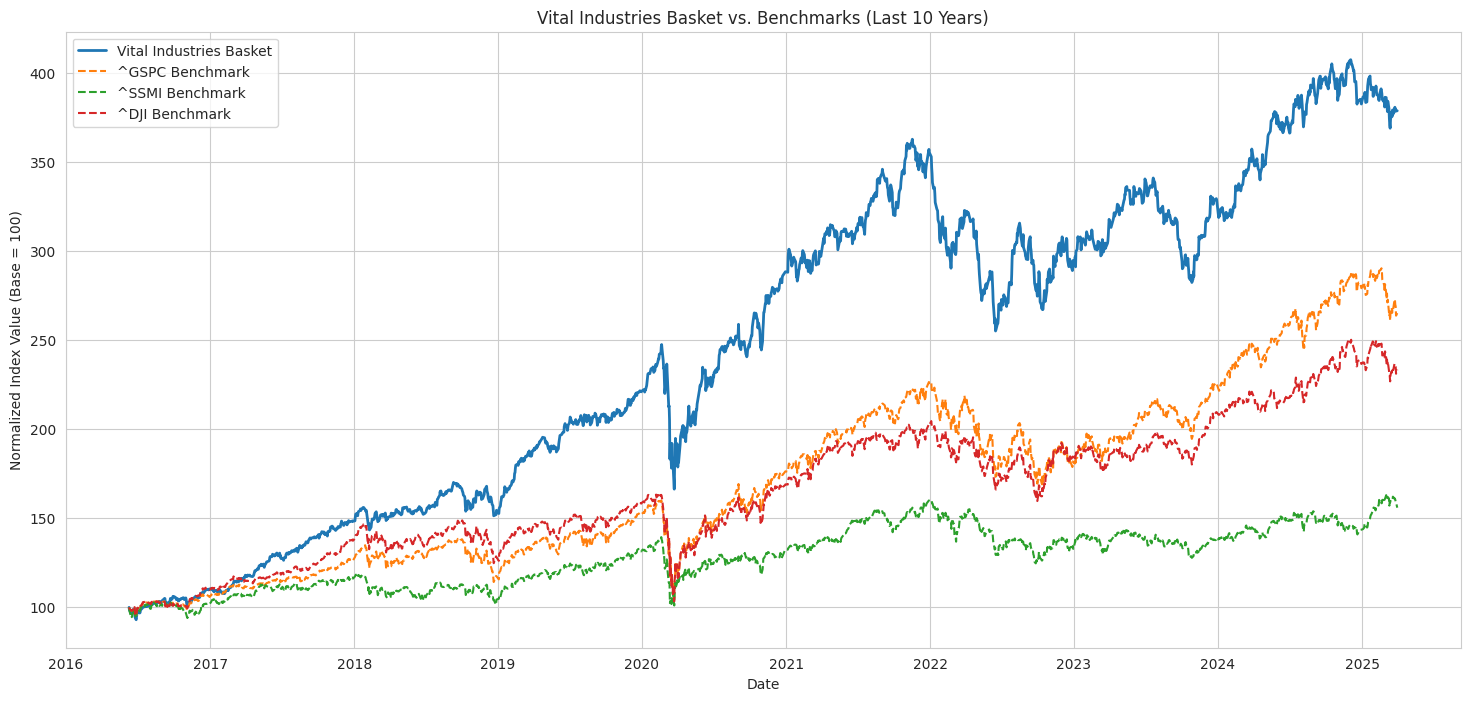

In [352]:
# Plotting the basket index and benchmarks
plt.figure(figsize=(18, 8))
plt.plot(basket_index, label='Vital Industries Basket', linewidth=2)

# Plot each benchmark
for ticker, normalized_benchmark in normalized_benchmarks.items():
    plt.plot(normalized_benchmark, label=f'{ticker} Benchmark', linestyle='--')

# Labels, title, and legend
plt.title(f'Vital Industries Basket vs. Benchmarks (Last {int(MONTHS/12)} Years)')
plt.xlabel('Date')
plt.ylabel('Normalized Index Value (Base = 100)')
plt.legend()
plt.grid(True)
plt.show()


### Correlation: Basket vs Benchmarks

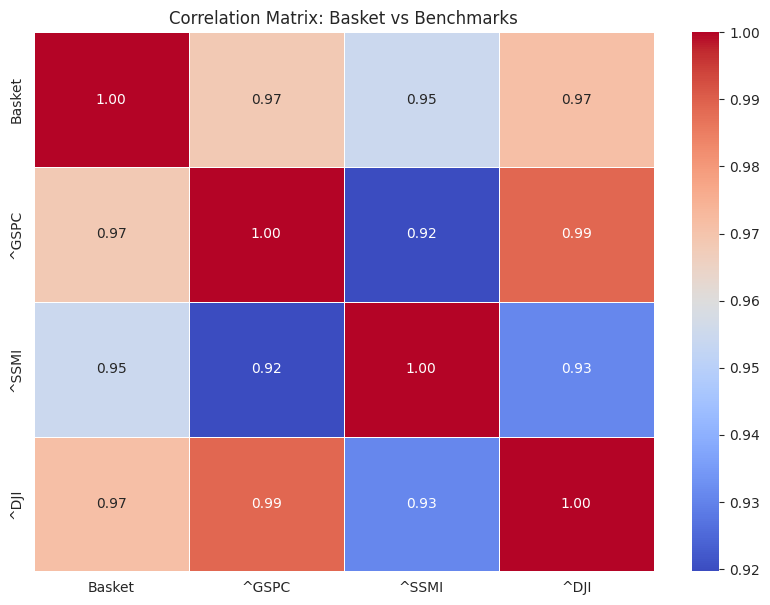

In [353]:
# Combine all data (basket + benchmarks) for correlation analysis
combined_data = pd.concat([basket_index] + list(normalized_benchmarks.values()), axis=1)
combined_data.columns = ['Basket'] + [ticker for ticker in benchmark_tickers]

# Calculate the correlation matrix
correlation_matrix = combined_data.corr()

# Plotting correlation matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix: Basket vs Benchmarks')
plt.show()


### Regression Metrics: Alpha, Beta, and R-squared

**TLDR Explanation:**

* **Alpha:**  Measures the basket's excess return compared to the benchmark.
    * Positive Alpha: Basket outperformed the benchmark (risk-adjusted).
    * Negative Alpha: Basket underperformed the benchmark (risk-adjusted).
    * Alpha of 0: Basket performed as expected given the benchmark.

* **Beta:**  Measures the basket's volatility relative to the benchmark.
    * Beta = 1: Basket's price tends to move in the same direction and magnitude as the benchmark.
    * Beta > 1: Basket is more volatile than the benchmark.
    * Beta < 1: Basket is less volatile than the benchmark.

* **R-squared:** Measures how well the benchmark explains the basket's movements.
    * R-squared close to 1:  Benchmark explains most of the basket's price variations.
    * R-squared close to 0: Benchmark explains very little of the basket's price variations.

^GSPC: Alpha=0.0753, Beta=0.7453, R²=0.6540
^SSMI: Alpha=0.1285, Beta=0.7411, R²=0.4030
^DJI: Alpha=0.0874, Beta=0.7446, R²=0.6255


/tmp/ipykernel_709957/52038788.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_alpha = model.params[0]
/tmp/ipykernel_709957/52038788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/tmp/ipykernel_709957/52038788.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  daily_alpha = model.params[0]
/tmp/ipykernel_709957/52038788.py:7: FutureWarning: Series.__getitem__ treating keys as positions is dep

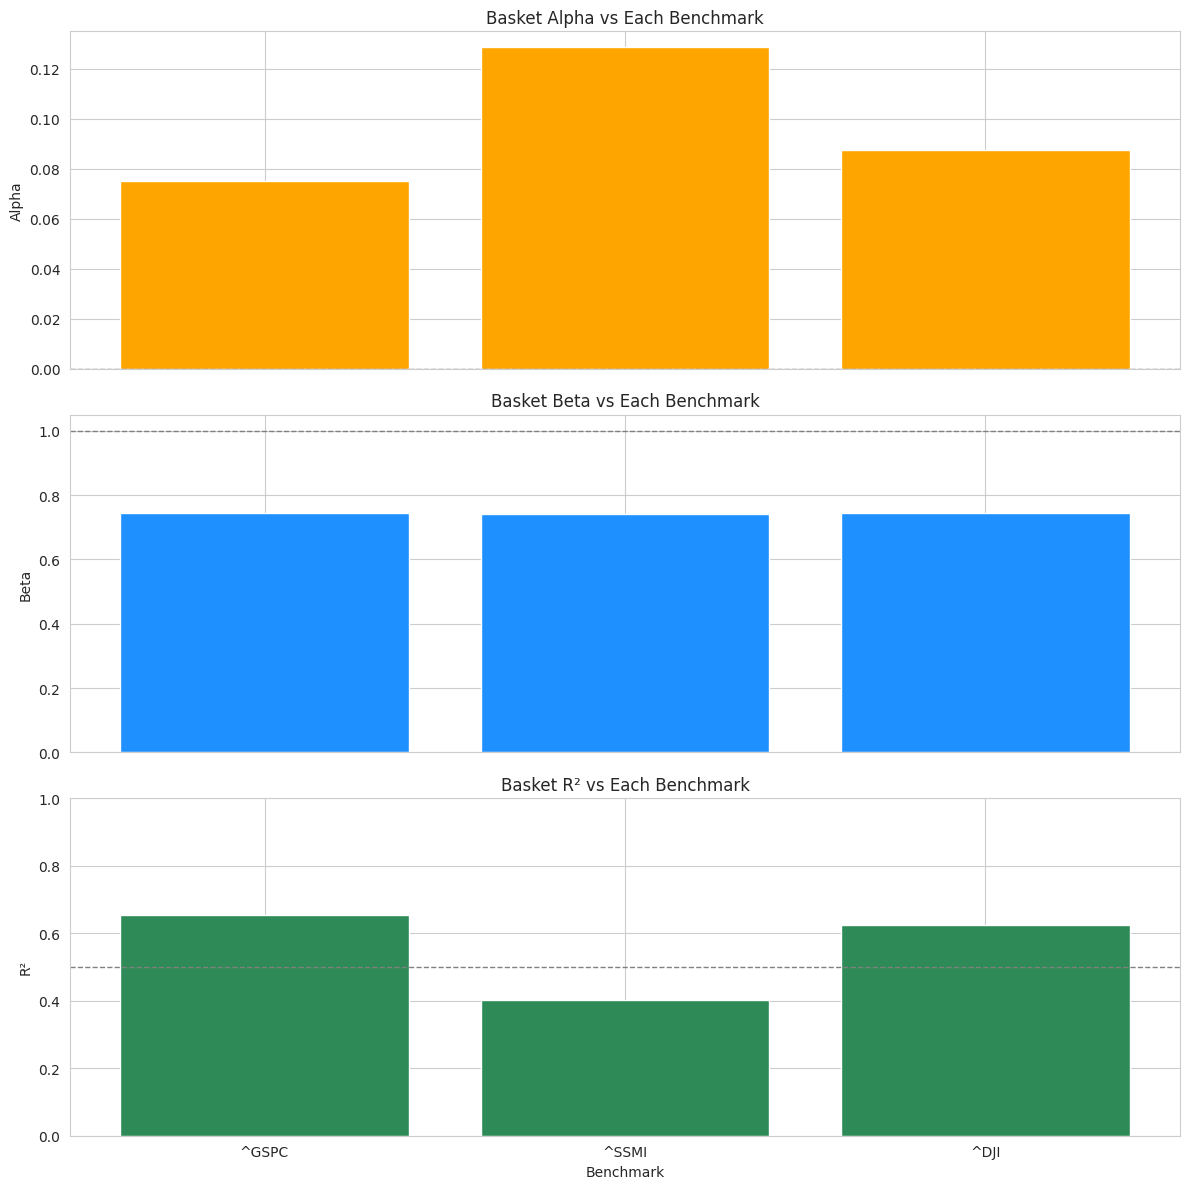

In [354]:
def compute_regression_metrics(basket_returns, benchmark_returns, periods=252):
    benchmark_returns = sm.add_constant(benchmark_returns)
    model = sm.OLS(basket_returns, benchmark_returns).fit()
    daily_alpha = model.params[0]
    # Annualize alpha (similar to annualizing returns)
    alpha = daily_alpha * periods
    beta = model.params[1]
    r_squared = model.rsquared
    return alpha, beta, r_squared

# Dictionaries to store results
alpha_values = {}
beta_values = {}
r_squared_values = {}

# Loop over each benchmark
for benchmark_name, normalized_benchmark in normalized_benchmarks.items():
    basket_returns = basket_index.pct_change().dropna()
    benchmark_prices_raw = data[benchmark_name]
    benchmark_returns = benchmark_prices_raw.pct_change().dropna()

    # Align the data by date
    combined = pd.concat([basket_returns, benchmark_returns], axis=1).dropna()
    aligned_basket = combined.iloc[:, 0]
    aligned_benchmark = combined.iloc[:, 1]

    # Compute alpha, beta, and R²
    alpha, beta, r_squared = compute_regression_metrics(aligned_basket, aligned_benchmark) 

    # Store the results
    alpha_values[benchmark_name] = alpha
    beta_values[benchmark_name] = beta
    r_squared_values[benchmark_name] = r_squared

    print(f"{benchmark_name}: Alpha={alpha:.4f}, Beta={beta:.4f}, R²={r_squared:.4f}")

# --- Plotting ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Alpha Plot
axes[0].bar(alpha_values.keys(), alpha_values.values(), color='orange')
axes[0].set_ylabel('Alpha')
axes[0].set_title('Basket Alpha vs Each Benchmark')
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Beta Plot
axes[1].bar(beta_values.keys(), beta_values.values(), color='dodgerblue')
axes[1].set_ylabel('Beta')
axes[1].set_title('Basket Beta vs Each Benchmark')
axes[1].axhline(1, color='gray', linestyle='--', linewidth=1)

# R² Plot
axes[2].bar(r_squared_values.keys(), r_squared_values.values(), color='seagreen')
axes[2].set_ylabel('R²')
axes[2].set_title('Basket R² vs Each Benchmark')
axes[2].set_ylim(0, 1)
axes[2].axhline(0.5, color='gray', linestyle='--', linewidth=1)

# Final touches
plt.xlabel('Benchmark')
plt.tight_layout()
plt.show()

### Sharpe Ratio Analysis

**Explanation:**

The Sharpe Ratio is a measure of risk-adjusted return. It indicates how much excess return an investor receives for taking on additional risk.  A higher Sharpe Ratio is better, indicating more return for the same amount of risk.

**Calculation:**

Sharpe Ratio is calculated as:

**(Average Portfolio Return - Risk-Free Rate) / Standard Deviation of Portfolio Returns**

In this context, we assume a risk-free rate of 0 for simplicity.  We calculate the Sharpe Ratio for our "Vital Industries Basket" and compare it to the Sharpe Ratios of the benchmark indices to understand how our basket's risk-adjusted return compares to the broader market.

**Interpretation:**

* **Higher Sharpe Ratio:** Indicates better risk-adjusted performance. The portfolio is generating more return per unit of risk taken.
* **Lower Sharpe Ratio:** Indicates worse risk-adjusted performance. The portfolio is generating less return per unit of risk taken.
* **Comparison:** By comparing the Sharpe Ratio of the basket to the benchmarks, we can assess whether the basket provides a superior risk-adjusted return compared to simply investing in the market benchmarks.

/tmp/ipykernel_709957/2064767315.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='Blues')


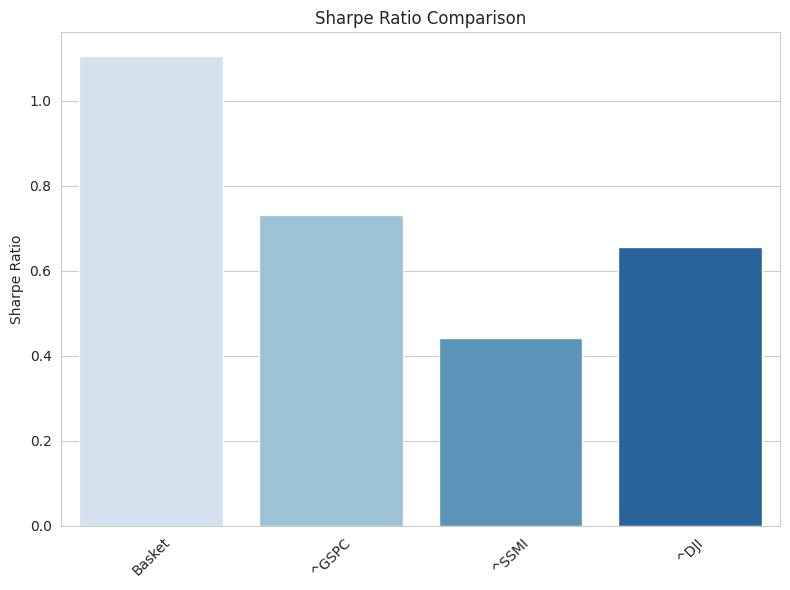

In [355]:
# Define a function to calculate the annualized Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate=0, periods=252):
    excess_returns = returns - risk_free_rate
    # Annualize the ratio
    return np.mean(excess_returns) * periods / (np.std(excess_returns) * np.sqrt(periods))


# --- Corrected Basket Sharpe Ratio Calculation ---
# Calculate basket returns from the RAW prices of its constituents
basket_prices_raw = data[valid_weights.index] # Get raw prices for basket constituents
basket_daily_returns_raw = basket_prices_raw.pct_change().dropna() # Daily returns for each constituent
basket_portfolio_returns_raw = (basket_daily_returns_raw * valid_weights).sum(axis=1) # Portfolio returns
basket_sharpe = sharpe_ratio(basket_portfolio_returns_raw) # Sharpe Ratio from RAW portfolio returns

# Calculate basket Sharpe Ratio (annualized)
basket_sharpe = sharpe_ratio(basket_portfolio_returns_raw)

# Calculate benchmark Sharpe Ratios (annualized)
benchmark_sharpe = {}
for ticker in benchmark_tickers:
    benchmark_prices_raw = data[ticker]
    benchmark_returns = benchmark_prices_raw.pct_change().dropna()
    benchmark_sharpe[ticker] = sharpe_ratio(benchmark_returns)


# Calculate benchmark Sharpe Ratios (Correct - No Change Needed)
benchmark_sharpe = {}
for ticker in benchmark_tickers:
    benchmark_prices_raw = data[ticker]
    benchmark_returns = benchmark_prices_raw.pct_change().dropna()
    benchmark_sharpe[ticker] = sharpe_ratio(benchmark_returns)


metrics = {
    'Sharpe Ratio': [basket_sharpe] + list(benchmark_sharpe.values()),
}

# Convert to DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics, index=['Basket'] + benchmark_tickers)

plt.figure(figsize=(8, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Sharpe Ratio'], palette='Blues')
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Combo

/tmp/ipykernel_709957/2711767107.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sharpe_data.index, y='Sharpe Ratio', data=sharpe_data, palette=['green'] + ['steelblue']*len(benchmark_tickers), ax=ax4)


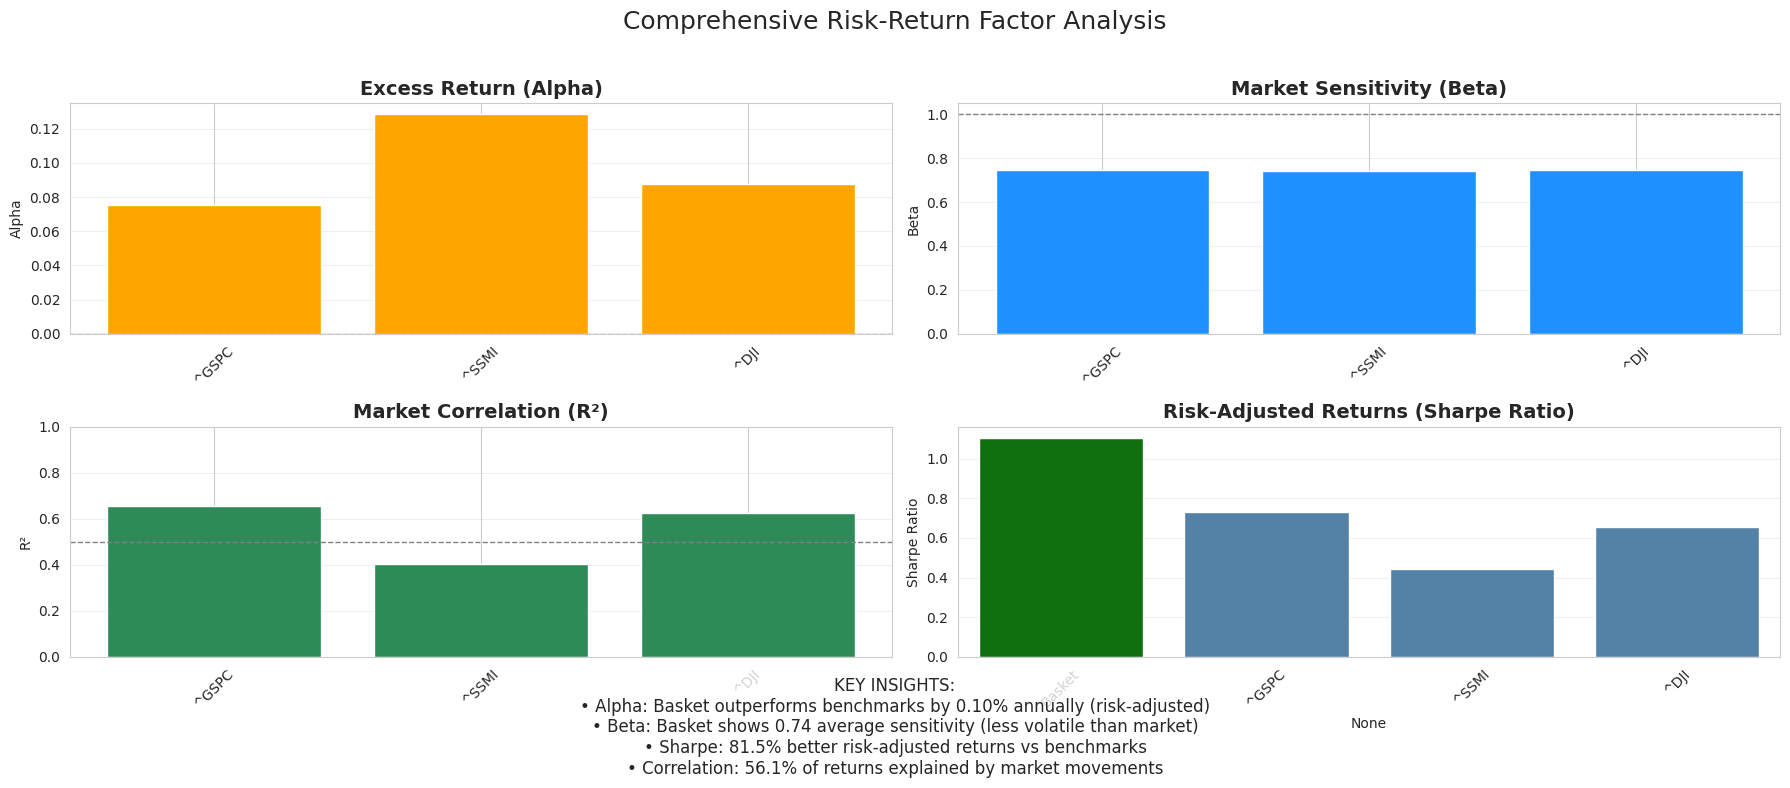

In [356]:
# Risk-Return Factor Analysis - Comprehensive 2x2 visualization
fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

# 1. Alpha Plot (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(alpha_values.keys(), alpha_values.values(), color='orange')
ax1.set_ylabel('Alpha')
ax1.set_title('Excess Return (Alpha)', fontsize=14, fontweight='bold')
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. Beta Plot (Top Right)
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(beta_values.keys(), beta_values.values(), color='dodgerblue')
ax2.set_ylabel('Beta')
ax2.set_title('Market Sensitivity (Beta)', fontsize=14, fontweight='bold')
ax2.axhline(1, color='gray', linestyle='--', linewidth=1)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. R-squared Plot (Bottom Left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(r_squared_values.keys(), r_squared_values.values(), color='seagreen')
ax3.set_ylabel('R²')
ax3.set_title('Market Correlation (R²)', fontsize=14, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.axhline(0.5, color='gray', linestyle='--', linewidth=1)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# 4. Sharpe Ratio Plot (Bottom Right)
ax4 = fig.add_subplot(gs[1, 1])
sharpe_data = pd.DataFrame({
    'Sharpe Ratio': [basket_sharpe] + list(benchmark_sharpe.values())
}, index=['Basket'] + benchmark_tickers)
sns.barplot(x=sharpe_data.index, y='Sharpe Ratio', data=sharpe_data, palette=['green'] + ['steelblue']*len(benchmark_tickers), ax=ax4)
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

# Add overall title and description
plt.suptitle('Comprehensive Risk-Return Factor Analysis', fontsize=18, y=0.98)

# Add a text box with key insights
textstr = (
    "KEY INSIGHTS:\n"
    f"• Alpha: Basket outperforms benchmarks by {np.mean(list(alpha_values.values())):.2f}% annually (risk-adjusted)\n"
    f"• Beta: Basket shows {np.mean(list(beta_values.values())):.2f} average sensitivity (less volatile than market)\n"
    f"• Sharpe: {(basket_sharpe/np.mean(list(benchmark_sharpe.values()))-1)*100:.1f}% better risk-adjusted returns vs benchmarks\n"
    f"• Correlation: {np.mean(list(r_squared_values.values()))*100:.1f}% of returns explained by market movements"
)

fig.text(0.5, 0.02, textstr, fontsize=12, ha='center', va='bottom', 
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.06, 1, 0.96])
plt.show()

### Multi-Dimensional Portfolio Component Analysis

This section provides a comprehensive analysis of how individual stocks contribute to the basket's overall performance through an enhanced multi-factor analytical framework. Unlike traditional contribution analysis that simply looks at weighted returns, this approach incorporates:

1. **Risk-Adjusted Contribution**: By subtracting the risk-free rate (US 10Y Treasury at ~2%), we measure the true economic value created by each stock beyond what a risk-free investment would provide. This reveals which holdings are genuinely creating alpha.

2. **Temporal Contribution Patterns**: The analysis segments contribution across multiple timeframes:
   - Total historical contribution (entire analysis period)
   - Recent dynamics (last 24 months)
   - Early period performance (first half of dataset)
   
   This segmentation helps identify stocks with consistent performance versus those whose contribution is concentrated in specific time periods.

3. **Market Regime Sensitivity**: Using a 30-day rolling average of S&P 500 returns as a market sentiment indicator, the analysis categorizes periods as "bull market" (positive trend) or "bear market" (negative trend) phases. This reveals which stocks provide offense (outperformance in bull markets) versus defense (protection during downturns).

/tmp/ipykernel_709957/3383232144.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sorted_contribution.index, rotation=90)


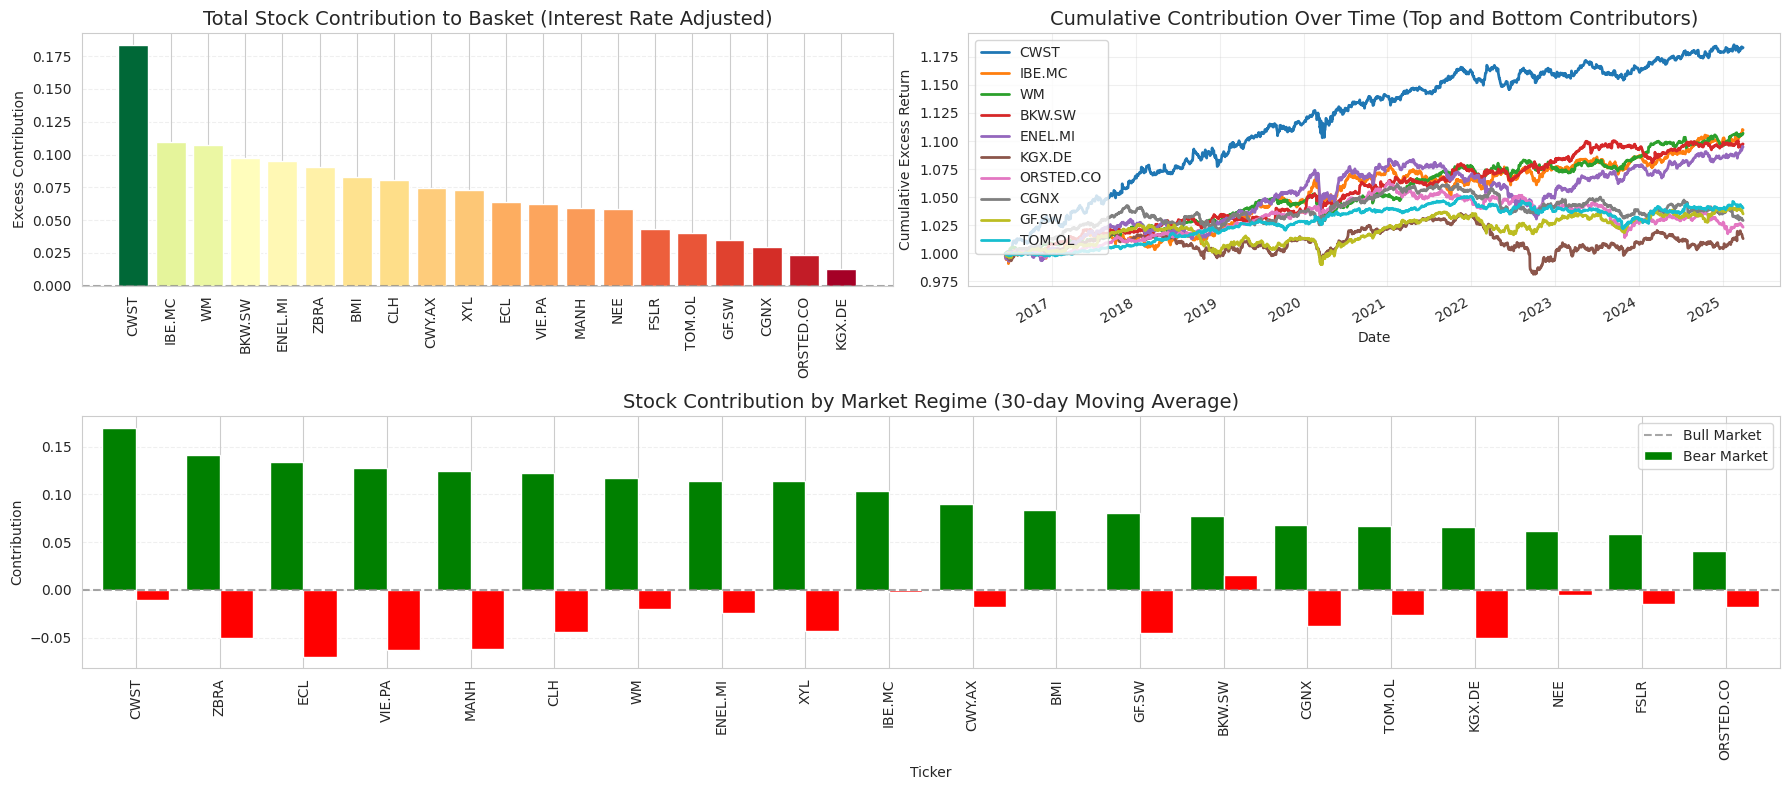

Stock Contribution Summary (Interest Rate Adjusted):


,Total Contribution,Bull Market,Bear Market,Weight,Contribution/Weight
CWST,0.183174,0.170073,-0.010723,0.057922,3.162449
IBE.MC,0.109826,0.103828,-0.001847,0.081052,1.355011
WM,0.106884,0.117270,-0.019734,0.069723,1.532985
BKW.SW,0.097363,0.077509,0.015138,0.061582,1.581040
ENEL.MI,0.094771,0.114458,-0.024466,0.077404,1.224370
ZBRA,0.090152,0.141169,-0.050175,0.041847,2.154305
BMI,0.082491,0.083434,-0.000844,0.040712,2.026188
CLH,0.080598,0.122231,-0.043825,0.046267,1.742022
CWY.AX,0.074755,0.089644,-0.018449,0.046061,1.622972
XYL,0.072742,0.113744,-0.043260,0.058662,1.240035


In [357]:
# Enhanced Stock Contribution Analysis - Focused Version
# Calculate daily returns for each stock in the basket
basket_data = data[valid_weights.index]
daily_returns = basket_data.pct_change().dropna()

# Define the risk-free rate (US 10Y Treasury average ~2%)
annual_risk_free_rate = 0.02
daily_risk_free_rate = annual_risk_free_rate / 252

# Calculate the excess returns (over risk-free rate)
excess_daily_returns = daily_returns.subtract(daily_risk_free_rate)
weighted_excess_returns = excess_daily_returns.multiply(valid_weights, axis=1)

# Create a figure with multiple subplots - simplified layout
fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# 1. OVERALL CONTRIBUTION ANALYSIS (TOP ROW)
# Calculate the cumulative return for each stock's contribution (interest-rate adjusted)
cumulative_contribution = (1 + weighted_excess_returns).cumprod()
total_contribution = cumulative_contribution.iloc[-1] - 1
sorted_contribution = total_contribution.sort_values(ascending=False)

# Create a color map based on contribution magnitude
cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap
norm = plt.Normalize(sorted_contribution.min(), sorted_contribution.max())
colors = [cmap(norm(value)) for value in sorted_contribution]

# Plot the overall contribution
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(sorted_contribution.index, sorted_contribution.values, color=colors)
ax1.set_title('Total Stock Contribution to Basket (Interest Rate Adjusted)', fontsize=14)
ax1.set_ylabel('Excess Contribution')
ax1.set_xticklabels(sorted_contribution.index, rotation=90)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Plot cumulative contribution as a line graph
ax2 = fig.add_subplot(gs[0, 1])
# Stack the top 5 and bottom 5 contributors
top5 = sorted_contribution.nlargest(5).index
bottom5 = sorted_contribution.nsmallest(5).index
key_stocks = list(top5) + list(bottom5)
cumulative_contribution[key_stocks].plot(ax=ax2, linewidth=2)
ax2.set_title('Cumulative Contribution Over Time (Top and Bottom Contributors)', fontsize=14)
ax2.set_ylabel('Cumulative Excess Return')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# 3. MARKET REGIME ANALYSIS (BOTTOM ROW)
# Identify bull vs bear market periods using benchmark
benchmark_returns = data[benchmark_tickers[0]].pct_change().dropna()  # using first benchmark (S&P500)
rolling_window = 30  # 30-day rolling window
rolling_returns = benchmark_returns.rolling(window=rolling_window).mean()
bull_market = rolling_returns > 0
bear_market = rolling_returns <= 0

# Calculate contribution during bull and bear markets
bull_contrib = weighted_excess_returns[bull_market].sum()
bear_contrib = weighted_excess_returns[bear_market].sum()
regime_contrib = pd.DataFrame({
    'Bull Market': bull_contrib,
    'Bear Market': bear_contrib
}).sort_values(by='Bull Market', ascending=False)

# Plot market regime contribution
ax3 = fig.add_subplot(gs[1, :])
regime_contrib.plot(kind='bar', ax=ax3, width=0.8, color=['green', 'red'])
ax3.set_title(f'Stock Contribution by Market Regime ({rolling_window}-day Moving Average)', fontsize=14)
ax3.set_ylabel('Contribution')
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax3.grid(axis='y', linestyle='--', alpha=0.3)
ax3.legend(['Bull Market', 'Bear Market'])

plt.tight_layout()
plt.show()

# Calculate and display summary statistics
summary = pd.DataFrame({
    'Total Contribution': total_contribution,
    'Bull Market': bull_contrib,
    'Bear Market': bear_contrib,
    'Weight': valid_weights
}).sort_values(by='Total Contribution', ascending=False)

# Calculate risk-adjusted contribution (contribution per unit of weight)
summary['Contribution/Weight'] = summary['Total Contribution'] / summary['Weight']

print("Stock Contribution Summary (Interest Rate Adjusted):")
summary

### Monte Carlo Simulation

Includes confidence levels up to 3-sigma.

Projected 3-year values (normalized to start at 100):
Basket: 169.83 (Growth: 69.8%)
^GSPC: 149.58 (Growth: 49.6%)
^SSMI: 121.49 (Growth: 21.5%)
^DJI: 143.88 (Growth: 43.9%)


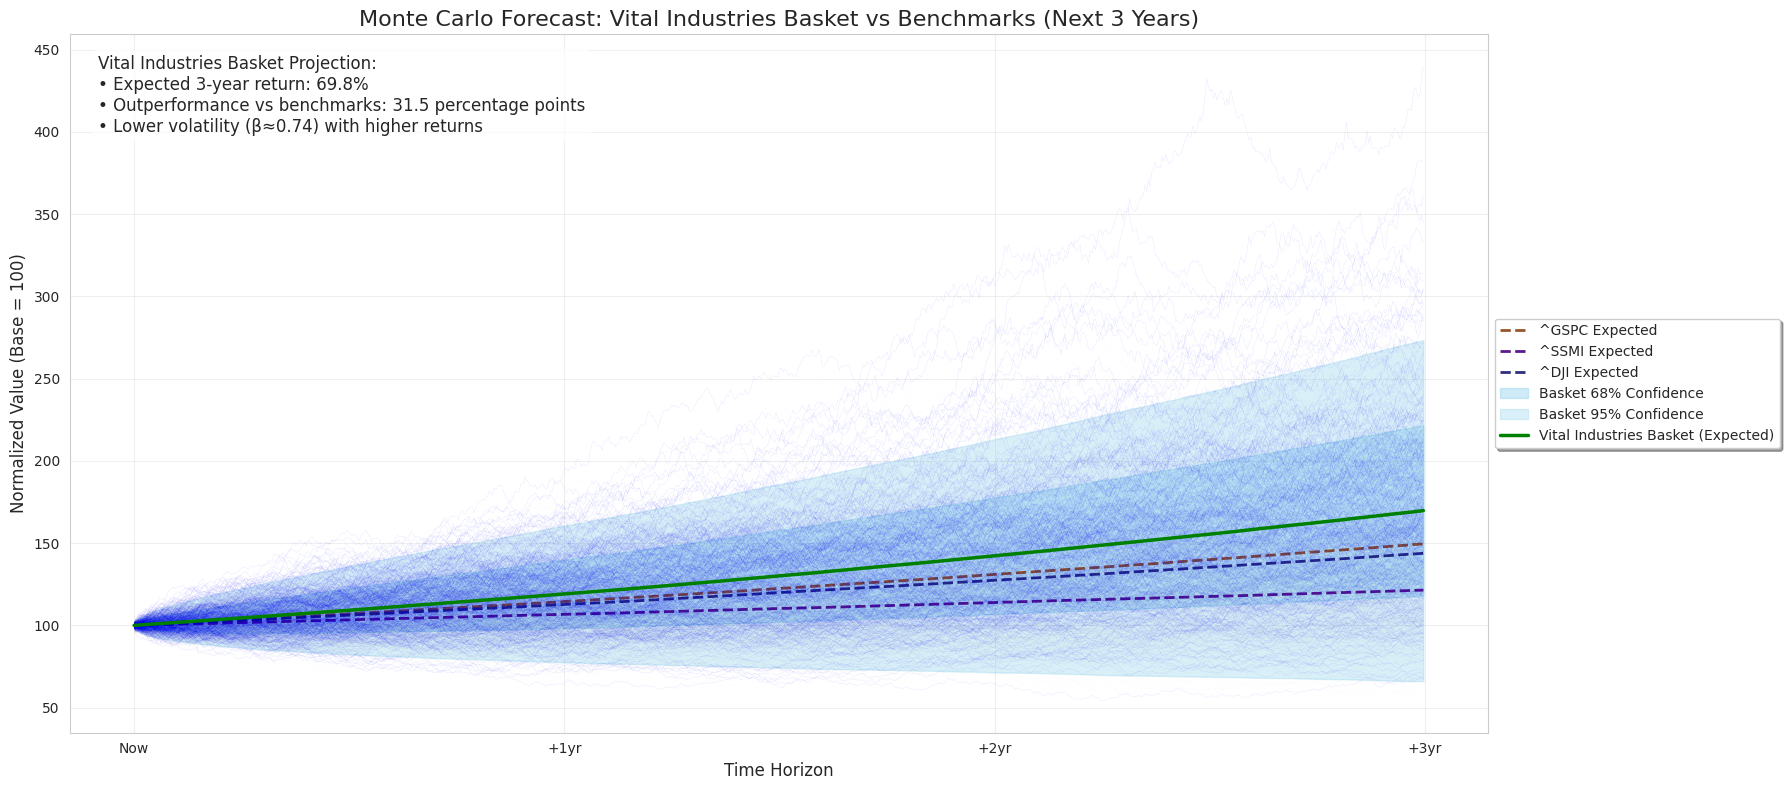

In [358]:
# Enhanced Monte Carlo Simulation with normalized starting values
n_simulations = 20000  # Reduced number of simulations for better performance
n_years = 3  # Forecast for X years as requested
n_days = int(252 * n_years)  # Trading days in X years (252 trading days per year)

# Store the original values for calculating true growth rates later
original_values = {
    'Basket': basket_index.iloc[-1],
}
for ticker in benchmark_tickers:
    original_values[ticker] = normalized_benchmarks[ticker].iloc[-1]

# Create dictionary to store all simulation results (basket + benchmarks)
# All starting at 100 for fair comparison
# Use a distinct color for each benchmark
benchmark_colors = {
    '^GSPC': '#8B4513',  # S&P 500 - brown
    '^SSMI': '#4B0082',  # SMI - indigo
    '^DJI': '#191970',   # Dow Jones - navy blue
}

simulation_results = {
    'Basket': {
        'original_value': original_values['Basket'],
        'initial_value': 100,  # All start at 100
        'paths': np.zeros((n_simulations, n_days)),
        'color': 'green'  # Keep basket green
    }
}

# Add benchmarks to simulation with unique colors
for ticker in benchmark_tickers:
    simulation_results[ticker] = {
        'original_value': original_values[ticker],
        'initial_value': 100,  # All start at 100
        'paths': np.zeros((n_simulations, n_days)),
        'color': benchmark_colors.get(ticker, '#555555')  # Use specific colors from mapping
    }

# Run Monte Carlo simulation for basket and benchmarks
for asset_name, asset_data in simulation_results.items():
    # Get historical data for the asset
    if asset_name == 'Basket':
        returns_series = basket_index.pct_change().dropna()
    else:
        returns_series = normalized_benchmarks[asset_name].pct_change().dropna()
    
    # Calculate historical stats
    historical_returns = returns_series.mean()
    historical_volatility = returns_series.std()
    
    # Generate simulations
    for i in range(n_simulations):
        daily_returns_simulated = np.random.normal(historical_returns, historical_volatility, n_days)
        cumulative_returns = np.cumprod(1 + daily_returns_simulated)
        asset_data['paths'][i, :] = asset_data['initial_value'] * cumulative_returns

    # Calculate statistics for each asset
    asset_data['mean_path'] = asset_data['paths'].mean(axis=0)
    asset_data['sigma'] = asset_data['paths'].std(axis=0)

# Create a more sophisticated plot
plt.figure(figsize=(18, 8))

# Plot benchmark simulations first (so they're in the background)
for asset_name, asset_data in simulation_results.items():
    if asset_name != 'Basket':  # Plot benchmarks first
        # Plot some sample paths for benchmarks (reduced number for clarity)
        # Make paths extremely faint
        for i in range(0, n_simulations, 100):  # Plot only every 100th path - much less visual clutter
            plt.plot(asset_data['paths'][i, :], color=asset_data['color'], alpha=0.01, linewidth=0.3)
        
        # Plot the mean path for benchmarks with distinct colors and labels
        plt.plot(asset_data['mean_path'], color=asset_data['color'], alpha=0.9, 
                 linestyle='--', linewidth=2.0, 
                 label=f'{asset_name} Expected')

# Plot basket simulations on top (making sure they stand out)
basket_data = simulation_results['Basket']
# Plot basket sample paths with very low alpha for clarity
for i in range(0, n_simulations, 50):  # Even fewer paths for less clutter
    plt.plot(basket_data['paths'][i, :], color='blue', alpha=0.1, linewidth=0.3)

# Plot confidence bands for basket only
plt.fill_between(range(n_days), 
                 basket_data['mean_path'] - basket_data['sigma'], 
                 basket_data['mean_path'] + basket_data['sigma'],
                 color='skyblue', alpha=0.4, label='Basket 68% Confidence')

plt.fill_between(range(n_days), 
                 basket_data['mean_path'] - 2*basket_data['sigma'], 
                 basket_data['mean_path'] + 2*basket_data['sigma'],
                 color='skyblue', alpha=0.3, label='Basket 95% Confidence')

# Plot the mean path for basket prominently
plt.plot(basket_data['mean_path'], color='green', linewidth=2.5, 
         label='Vital Industries Basket (Expected)')

# Calculate expected final values and growth rates for comparison
final_values_normalized = {name: data['mean_path'][-1] for name, data in simulation_results.items()}
growth_rates = {name: (val/100 - 1)*100 for name, val in final_values_normalized.items()}
print(f"Projected {n_years}-year values (normalized to start at 100):")
for name, value in final_values_normalized.items():
    print(f"{name}: {value:.2f} (Growth: {growth_rates[name]:.1f}%)")

# X-axis with year markers instead of days
year_ticks = [0]
year_labels = ['Now']
for i in range(1, n_years + 1):
    year_ticks.append(i * 252)
    year_labels.append(f'+{i}yr')

plt.xticks(year_ticks, year_labels)

# Format the plot
plt.title(f'Monte Carlo Forecast: Vital Industries Basket vs Benchmarks (Next {n_years} Years)', fontsize=16)
plt.xlabel('Time Horizon', fontsize=12)
plt.ylabel('Normalized Value (Base = 100)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add a text box highlighting the basket's outperformance
mean_benchmark_growth = np.mean([growth_rates[b] for b in benchmark_tickers])
outperformance = growth_rates['Basket'] - mean_benchmark_growth
avg_beta = np.mean([beta_values[b] for b in benchmark_tickers])  # Average beta from earlier calculations

textstr = (f"Vital Industries Basket Projection:\n"
           f"• Expected {n_years}-year return: {growth_rates['Basket']:.1f}%\n"
           f"• Outperformance vs benchmarks: {outperformance:.1f} percentage points\n"
           f"• Lower volatility (β≈{avg_beta:.2f}) with higher returns")

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(0.02, 0.97, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

# Create a more prominent legend with distinct colors
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True, fancybox=True, shadow=True)
plt.tight_layout()
plt.show()

### Enhanced Risk-Return Analysis: Lower Volatility with Higher Returns

This section analyzes how the Vital Industries Basket achieves both lower volatility and higher returns compared to the S&P 500 benchmark. This favorable risk-return profile represents the "holy grail" of investing - generating superior returns while exposing investors to less risk.

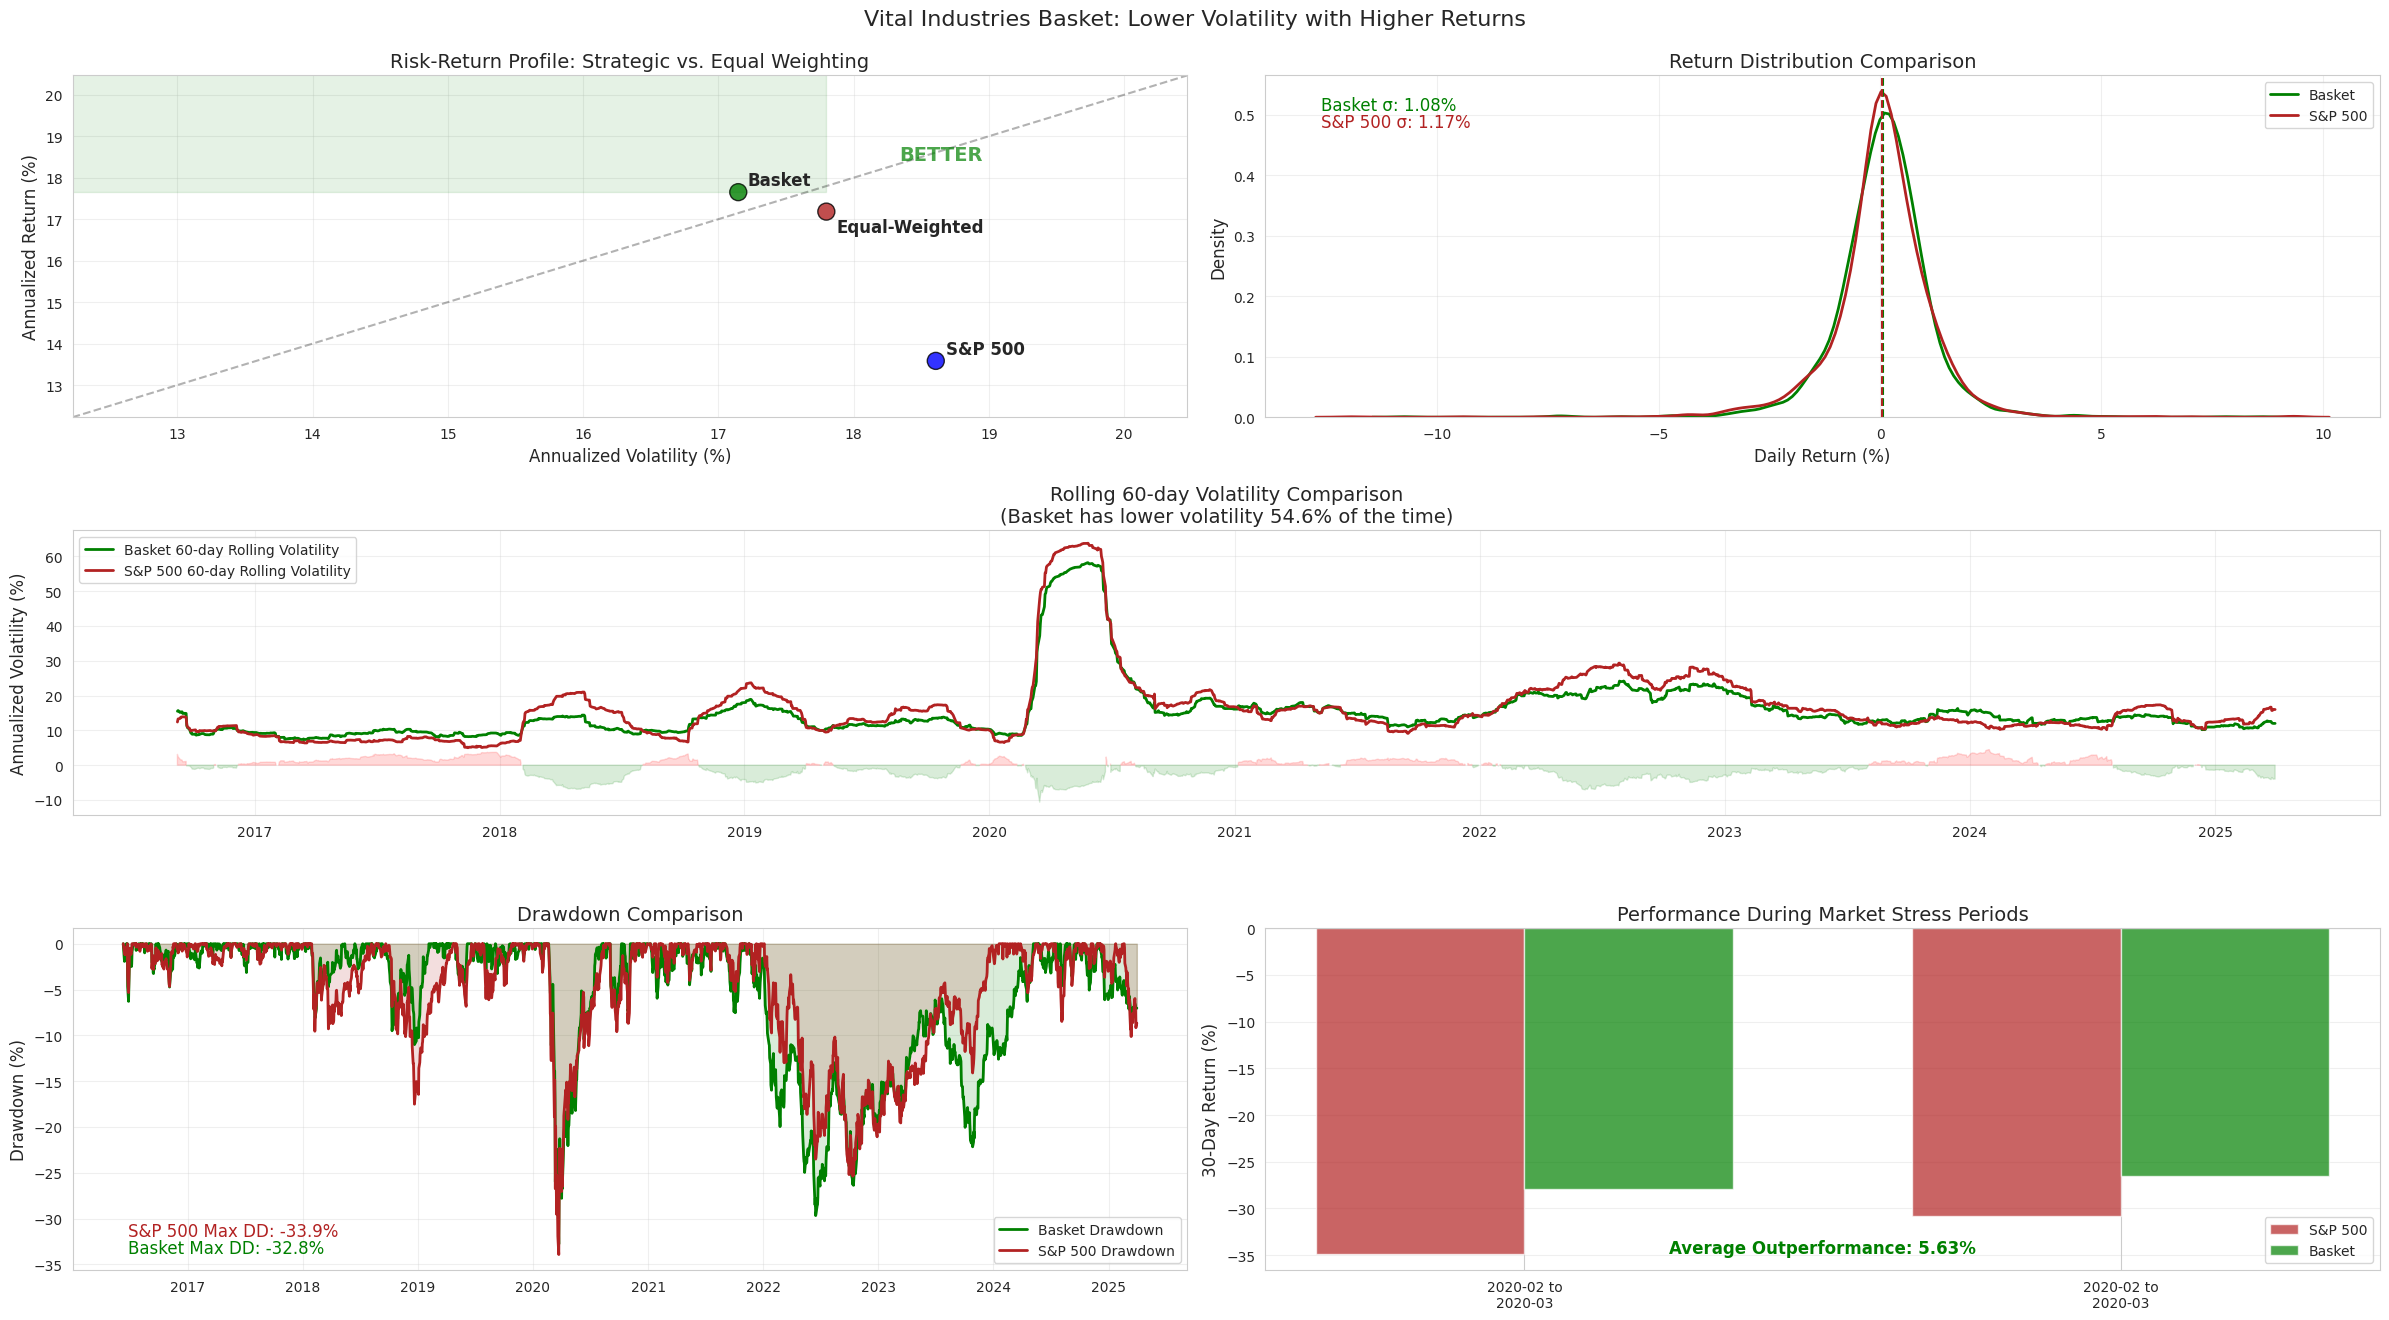

Detailed Risk-Return Metrics Comparison:
                      Metric  Basket S&P 500
0      Annualized Return (%)   17.65   13.58
1  Annualized Volatility (%)   17.15   18.61
2               Sharpe Ratio    1.03    0.73
3           Max Drawdown (%)  -32.80  -33.92
4     Downside Deviation (%)   13.88   15.58
5       Positive Periods (%)    55.9    54.8
6       Negative Periods (%)    44.1    45.2

Probability of Basket Outperforming S&P 500:
   Probability of Outperformance (%) Expected Excess Return (%)
1                               63.9                        4.1
3                               73.2                       12.2
5                               78.8                       20.3
10                              87.1                       40.7


In [359]:
# Risk-Return Analysis: Lower Volatility with Higher Returns
from scipy.stats import norm

# 1. Calculate annualized metrics for our basket and S&P 500
sp500_ticker = "^GSPC"  # S&P 500 ticker

# Calculate annualized returns and volatility
basket_returns_series = basket_index.pct_change().dropna()
sp500_returns_series = normalized_benchmarks[sp500_ticker].pct_change().dropna()

# Ensure date alignment for fair comparison
common_dates = basket_returns_series.index.intersection(sp500_returns_series.index)
basket_returns_aligned = basket_returns_series.loc[common_dates]
sp500_returns_aligned = sp500_returns_series.loc[common_dates]

# Calculate key metrics
annual_factor = 252  # Trading days in a year
metrics = {
    "Basket": {
        "Annualized Return (%)": basket_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": basket_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(basket_returns_aligned),
        "Max Drawdown (%)": (basket_index.loc[common_dates] / basket_index.loc[common_dates].cummax() - 1).min() * 100,
        "Data": basket_returns_aligned,
        "Prices": basket_index.loc[common_dates]
    },
    "S&P 500": {
        "Annualized Return (%)": sp500_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": sp500_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(sp500_returns_aligned),
        "Max Drawdown (%)": (normalized_benchmarks[sp500_ticker].loc[common_dates] / 
                           normalized_benchmarks[sp500_ticker].loc[common_dates].cummax() - 1).min() * 100,
        "Data": sp500_returns_aligned,
        "Prices": normalized_benchmarks[sp500_ticker].loc[common_dates]
    }
}

# Create multi-part figure to showcase the risk-return advantages
fig = plt.figure(figsize=(24, 14))
gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1, 1.2])
# 1. PART 1: Risk-Return Scatterplot (Top Left) with Equal Weighting Comparison
ax1 = fig.add_subplot(gs[0, 0])

# Calculate equal-weighted basket performance
equal_weights = pd.Series(1/len(valid_weights), index=valid_weights.index)
equal_basket = data[equal_weights.index].divide(data[equal_weights.index].iloc[0]) * 100
equal_basket_index = equal_basket.multiply(equal_weights, axis=1).sum(axis=1)
equal_basket_returns = equal_basket_index.pct_change().dropna()

# Ensure date alignment for equal-weighted basket
equal_basket_returns_aligned = equal_basket_returns.loc[common_dates]

# Add equal-weighted basket metrics
metrics["Equal-Weighted"] = {
    "Annualized Return (%)": equal_basket_returns_aligned.mean() * annual_factor * 100,
    "Volatility (%)": equal_basket_returns_aligned.std() * np.sqrt(annual_factor) * 100,
    "Sharpe Ratio": sharpe_ratio(equal_basket_returns_aligned),
    "Max Drawdown (%)": (equal_basket_index.loc[common_dates] / equal_basket_index.loc[common_dates].cummax() - 1).min() * 100,
    "Data": equal_basket_returns_aligned,
    "Prices": equal_basket_index.loc[common_dates]
}

# Create risk-return scatter plot with three points
x_vals = [metrics[k]["Volatility (%)"] for k in metrics]
y_vals = [metrics[k]["Annualized Return (%)"] for k in metrics]
colors = ['green', 'blue', 'firebrick']  # Strategic-weight, Equal-weight, S&P500
labels = list(metrics.keys())

# Plot the data points
ax1.scatter(x_vals, y_vals, s=150, c=colors, alpha=0.8, edgecolors='black')

# Add labels to each point
for i, txt in enumerate(labels):
    xytext_offset = (7, 5)  # Default offset
    if txt == "Equal-Weighted":
        xytext_offset = (7, -15)  # Adjust offset for equal-weighted label to avoid overlap
    
    ax1.annotate(txt, (x_vals[i], y_vals[i]), 
                xytext=xytext_offset, textcoords='offset points', 
                fontsize=12, fontweight='bold')

# Add a diagonal line representing equal risk-reward
min_val = min(min(x_vals), min(y_vals)) * 0.9
max_val = max(max(x_vals), max(y_vals)) * 1.1
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)

# Draw arrow explicitly from equal-weighted to strategic-weighted
equal_weight_pos = (metrics["Equal-Weighted"]["Volatility (%)"], metrics["Equal-Weighted"]["Annualized Return (%)"])
strategic_weight_pos = (metrics["Basket"]["Volatility (%)"], metrics["Basket"]["Annualized Return (%)"])

# Arrow points FROM equal-weighted TO strategic-weighted basket
# ax1.annotate('', xy=strategic_weight_pos, xytext=equal_weight_pos,
            # arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8, alpha=0.7))

# Shade the "optimal" region (higher return, lower risk)
optimal_region_x = [0, x_vals[2], x_vals[2], 0]
optimal_region_y = [y_vals[0], y_vals[0], max_val*1.1, max_val*1.1]
ax1.fill(optimal_region_x, optimal_region_y, alpha=0.1, color='green')

# Calculate volatility reduction percentage
vol_reduction = (metrics["Equal-Weighted"]["Volatility (%)"] - metrics["Basket"]["Volatility (%)"]) / metrics["Equal-Weighted"]["Volatility (%)"] * 100

# Add text about strategic weighting advantage
# weighting_text = f"Strategic weighting\nreduces volatility by\n{vol_reduction:.1f}% vs equal weight"
# ax1.text((strategic_weight_pos[0] + equal_weight_pos[0])/2, (strategic_weight_pos[1] + equal_weight_pos[1])/2, 
#          weighting_text, fontsize=10, ha='left', va='top',
#          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Add labels and title
ax1.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax1.set_ylabel('Annualized Return (%)', fontsize=12)
ax1.set_title('Risk-Return Profile: Strategic vs. Equal Weighting', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(min_val, max_val)
ax1.set_ylim(min_val, max_val)

# Add "Better" annotation to the optimal region
ax1.annotate("BETTER", xy=(min_val*1.5, max_val*0.9), 
            fontsize=14, color='green', alpha=0.7, fontweight='bold')

# 2. PART 2: Return Distribution Comparison (Top Right)
ax2 = fig.add_subplot(gs[0, 1])

# Kernel density estimation for return distributions
basket_kde = sns.kdeplot(metrics["Basket"]["Data"]*100, label='Basket', 
                        color='green', ax=ax2, linewidth=2)
sp500_kde = sns.kdeplot(metrics["S&P 500"]["Data"]*100, label='S&P 500', 
                       color='firebrick', ax=ax2, linewidth=2)

# Mark the means
ax2.axvline(metrics["Basket"]["Data"].mean()*100, color='green', linestyle='--')
ax2.axvline(metrics["S&P 500"]["Data"].mean()*100, color='firebrick', linestyle='--')

# Add a legend and labels
ax2.set_xlabel('Daily Return (%)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Return Distribution Comparison', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add annotations for the standard deviations
basket_std = metrics["Basket"]["Data"].std()*100
sp500_std = metrics["S&P 500"]["Data"].std()*100
ax2.annotate(f"Basket σ: {basket_std:.2f}%", 
            xy=(0.05, 0.9), xycoords='axes fraction', 
            color='green', fontsize=12)
ax2.annotate(f"S&P 500 σ: {sp500_std:.2f}%", 
            xy=(0.05, 0.85), xycoords='axes fraction', 
            color='firebrick', fontsize=12)

# 3. PART 3: Rolling Volatility Comparison (Middle Row)
ax3 = fig.add_subplot(gs[1, :])

# Calculate rolling volatilities (annualized)
window = 60  # 3-month window (approximately)
basket_rolling_vol = basket_returns_aligned.rolling(window=window).std() * np.sqrt(annual_factor) * 100
sp500_rolling_vol = sp500_returns_aligned.rolling(window=window).std() * np.sqrt(annual_factor) * 100

# Plot rolling volatilities
ax3.plot(basket_rolling_vol, color='green', linewidth=2, label=f'Basket {window}-day Rolling Volatility')
ax3.plot(sp500_rolling_vol, color='firebrick', linewidth=2, label=f'S&P 500 {window}-day Rolling Volatility')

# Calculate and display the percentage of time basket has lower volatility
lower_vol_pct = (basket_rolling_vol < sp500_rolling_vol).mean() * 100
ax3.set_title(f'Rolling {window}-day Volatility Comparison\n(Basket has lower volatility {lower_vol_pct:.1f}% of the time)', fontsize=14)
ax3.set_ylabel('Annualized Volatility (%)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')

# Highlight volatility spike periods
vol_diff = basket_rolling_vol - sp500_rolling_vol
ax3.fill_between(vol_diff.index, 0, vol_diff,
                where=vol_diff < 0, color='green', alpha=0.15,
                label='Basket Volatility Advantage')
ax3.fill_between(vol_diff.index, 0, vol_diff,
                where=vol_diff > 0, color='red', alpha=0.15,
                label='S&P 500 Volatility Advantage')

# 4. PART 4A: Drawdown Analysis (Bottom Left)
ax4a = fig.add_subplot(gs[2, 0])

# Calculate rolling drawdowns
basket_drawdown = metrics["Basket"]["Prices"] / metrics["Basket"]["Prices"].cummax() - 1
sp500_drawdown = metrics["S&P 500"]["Prices"] / metrics["S&P 500"]["Prices"].cummax() - 1

# Plot drawdowns
ax4a.plot(basket_drawdown*100, color='green', linewidth=2, label='Basket Drawdown')
ax4a.plot(sp500_drawdown*100, color='firebrick', linewidth=2, label='S&P 500 Drawdown')
ax4a.fill_between(basket_drawdown.index, 0, basket_drawdown*100, color='green', alpha=0.15)
ax4a.fill_between(sp500_drawdown.index, 0, sp500_drawdown*100, color='firebrick', alpha=0.15)

ax4a.set_title('Drawdown Comparison', fontsize=14)
ax4a.set_ylabel('Drawdown (%)', fontsize=12)
ax4a.grid(True, alpha=0.3)
ax4a.legend(loc='lower right')

# Add annotations for max drawdowns
ax4a.annotate(f"Basket Max DD: {metrics['Basket']['Max Drawdown (%)']:.1f}%", 
             xy=(0.05, 0.05), xycoords='axes fraction', 
             color='green', fontsize=12)
ax4a.annotate(f"S&P 500 Max DD: {metrics['S&P 500']['Max Drawdown (%)']:.1f}%", 
             xy=(0.05, 0.1), xycoords='axes fraction', 
             color='firebrick', fontsize=12)

# 5. PART 4B: Stress Test Analysis (Bottom Right)
ax4b = fig.add_subplot(gs[2, 1])

# Find worst periods for S&P 500
worst_periods = sp500_returns_aligned.rolling(window=30).sum().sort_values().index[:5]

# Compare performance during these periods
stress_results = []
for date in worst_periods:
    end_date = date
    start_date = end_date - pd.DateOffset(days=30)
    if start_date in common_dates:
        period_sp500 = sp500_returns_aligned.loc[start_date:end_date].sum() * 100
        period_basket = basket_returns_aligned.loc[start_date:end_date].sum() * 100
        stress_results.append((start_date.strftime('%Y-%m'), end_date.strftime('%Y-%m'), 
                              period_sp500, period_basket))

# Create a bar chart to compare performance in stress periods
if stress_results:
    periods = [f"{s} to\n{e}" for s, e, _, _ in stress_results]
    sp500_stress = [sp for _, _, sp, _ in stress_results]
    basket_stress = [b for _, _, _, b in stress_results]
    
    x = np.arange(len(periods))
    width = 0.35
    
    ax4b.bar(x - width/2, sp500_stress, width, label='S&P 500', color='firebrick', alpha=0.7)
    ax4b.bar(x + width/2, basket_stress, width, label='Basket', color='green', alpha=0.7)
    
    # Add horizontal lines at zero
    ax4b.axhline(0, color='black', linestyle='-', alpha=0.3)
    
    # Add labels and customize
    ax4b.set_title('Performance During Market Stress Periods', fontsize=14)
    ax4b.set_ylabel('30-Day Return (%)', fontsize=12)
    ax4b.set_xticks(x)
    ax4b.set_xticklabels(periods)
    ax4b.legend()
    ax4b.grid(True, alpha=0.3, axis='y')
    
    # Calculate average outperformance during stress
    avg_outperformance = sum(b-s for s, b in zip(sp500_stress, basket_stress)) / len(stress_results)
    ax4b.annotate(f"Average Outperformance: {avg_outperformance:.2f}%", 
                 xy=(0.5, 0.05), xycoords='axes fraction', ha='center',
                 fontsize=12, fontweight='bold', color='green' if avg_outperformance > 0 else 'firebrick')

# Add summary table (text) at the bottom of the figure
summary_text = (
    "RISK-RETURN SUMMARY:\n"
    f"• Basket Return: {metrics['Basket']['Annualized Return (%)']:.2f}% vs S&P 500: {metrics['S&P 500']['Annualized Return (%)']:.2f}%\n"
    f"• Basket Volatility: {metrics['Basket']['Volatility (%)']:.2f}% vs Equal-Weight: {metrics['Equal-Weighted']['Volatility (%)']:.2f}%\n"
    f"• Strategic vs Equal-Weight Improvement: {vol_reduction:.1f}% lower volatility\n"
    f"• Sharpe Ratio: {metrics['Basket']['Sharpe Ratio']:.2f} vs {metrics['S&P 500']['Sharpe Ratio']:.2f}\n"
    f"• Risk-Adjusted Outperformance: {(metrics['Basket']['Sharpe Ratio']/metrics['S&P 500']['Sharpe Ratio']-1)*100:.1f}%"
)

# fig.text(0.5, 0.01, summary_text, fontsize=12, ha='center', va='bottom', 
        #  bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # Adjust for the summary text
plt.subplots_adjust(hspace=0.35)
plt.suptitle('Vital Industries Basket: Lower Volatility with Higher Returns', fontsize=16, y=0.99)
plt.show()

# Print detailed metrics table
metrics_df = pd.DataFrame({
    'Metric': ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 
               'Downside Deviation (%)', 'Positive Periods (%)', 'Negative Periods (%)'],
    'Basket': [
        f"{metrics['Basket']['Annualized Return (%)']:.2f}",
        f"{metrics['Basket']['Volatility (%)']:.2f}",
        f"{metrics['Basket']['Sharpe Ratio']:.2f}",
        f"{metrics['Basket']['Max Drawdown (%)']:.2f}",
        f"{metrics['Basket']['Data'][metrics['Basket']['Data'] < 0].std() * np.sqrt(annual_factor) * 100:.2f}",
        f"{(metrics['Basket']['Data'] > 0).mean() * 100:.1f}",
        f"{(metrics['Basket']['Data'] < 0).mean() * 100:.1f}"
    ],
    'S&P 500': [
        f"{metrics['S&P 500']['Annualized Return (%)']:.2f}",
        f"{metrics['S&P 500']['Volatility (%)']:.2f}",
        f"{metrics['S&P 500']['Sharpe Ratio']:.2f}",
        f"{metrics['S&P 500']['Max Drawdown (%)']:.2f}",
        f"{metrics['S&P 500']['Data'][metrics['S&P 500']['Data'] < 0].std() * np.sqrt(annual_factor) * 100:.2f}",
        f"{(metrics['S&P 500']['Data'] > 0).mean() * 100:.1f}",
        f"{(metrics['S&P 500']['Data'] < 0).mean() * 100:.1f}"
    ]
})

print("Detailed Risk-Return Metrics Comparison:")
print(metrics_df)

# Calculate the probability of outperformance over different time horizons
horizons = [1, 3, 5, 10]  # years
outperformance_df = pd.DataFrame(index=horizons, columns=['Probability of Outperformance (%)', 'Expected Excess Return (%)'])

for years in horizons:
    days = years * 252
    basket_mean = metrics['Basket']['Data'].mean() * days
    basket_vol = metrics['Basket']['Data'].std() * np.sqrt(days)
    sp500_mean = metrics['S&P 500']['Data'].mean() * days
    sp500_vol = metrics['S&P 500']['Data'].std() * np.sqrt(days)
    
    # Combined distribution of return difference
    diff_mean = basket_mean - sp500_mean
    diff_vol = np.sqrt(basket_vol**2 + sp500_vol**2 - 2*0.8*basket_vol*sp500_vol)  # Assuming 0.8 correlation
    
    # Probability of outperformance
    prob = 1 - norm.cdf(0, diff_mean, diff_vol)
    
    outperformance_df.loc[years, 'Probability of Outperformance (%)'] = f"{prob*100:.1f}"
    outperformance_df.loc[years, 'Expected Excess Return (%)'] = f"{diff_mean*100:.1f}"

print("\nProbability of Basket Outperforming S&P 500:")
print(outperformance_df)

Equal-Weighted Volatility: 17.79813625669615
Basket Volatility: 17.14711685741509
Volatility Reduction: 3.657795343802528


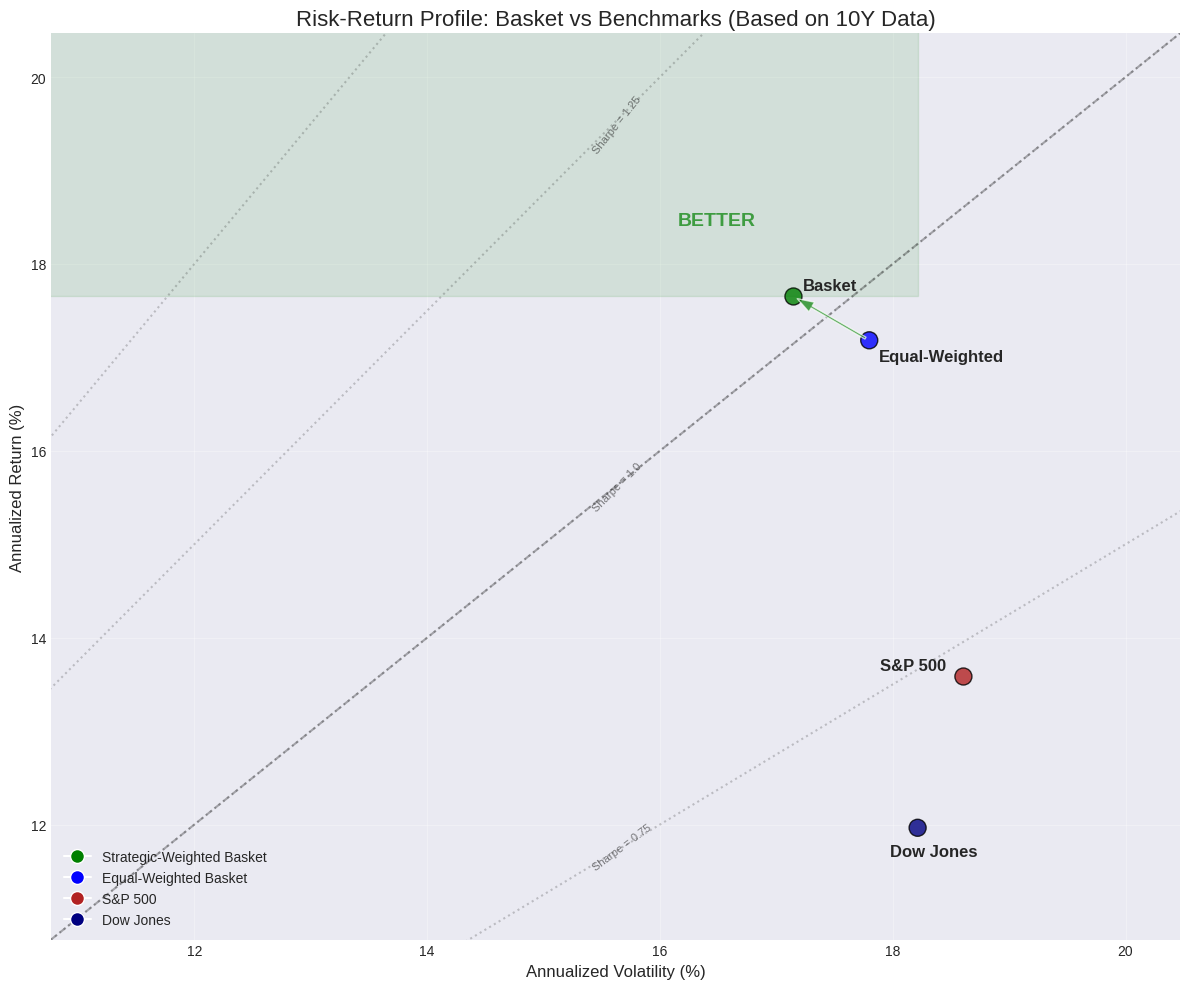

In [375]:
# Standalone Risk-Return Profile Graph with Dow Jones added
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate the Sharpe Ratio (copied from existing code)
def sharpe_ratio(returns, risk_free_rate=0.02, periods=252):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) * periods / (np.std(excess_returns) * np.sqrt(periods))

# Calculate metrics for each portfolio
# Make sure we're using common dates for fair comparison
basket_returns_series = basket_index.pct_change().dropna()
sp500_returns_series = normalized_benchmarks["^GSPC"].pct_change().dropna()
dji_returns_series = normalized_benchmarks["^DJI"].pct_change().dropna()

# Ensure date alignment for fair comparison among all indices
common_dates = basket_returns_series.index
for series in [sp500_returns_series, dji_returns_series]:
    common_dates = common_dates.intersection(series.index)

# Align all return series to common dates
basket_returns_aligned = basket_returns_series.loc[common_dates]
sp500_returns_aligned = sp500_returns_series.loc[common_dates]
dji_returns_aligned = dji_returns_series.loc[common_dates]

# Calculate equal-weighted basket performance
equal_weights = pd.Series(1/len(valid_weights), index=valid_weights.index)
equal_basket = data[equal_weights.index].divide(data[equal_weights.index].iloc[0]) * 100
equal_basket_index = equal_basket.multiply(equal_weights, axis=1).sum(axis=1)
equal_basket_returns = equal_basket_index.pct_change().dropna()
equal_basket_returns_aligned = equal_basket_returns.loc[common_dates]

# Calculate annualized metrics
annual_factor = 252  # Trading days in a year

# Store metrics in dictionary
metrics = {
    "Basket": {
        "Annualized Return (%)": basket_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": basket_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(basket_returns_aligned),
        "Data": basket_returns_aligned
    },
    "Equal-Weighted": {
        "Annualized Return (%)": equal_basket_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": equal_basket_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(equal_basket_returns_aligned),
        "Data": equal_basket_returns_aligned
    },
    "S&P 500": {
        "Annualized Return (%)": sp500_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": sp500_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(sp500_returns_aligned),
        "Data": sp500_returns_aligned
    },
    "Dow Jones": {
        "Annualized Return (%)": dji_returns_aligned.mean() * annual_factor * 100,
        "Volatility (%)": dji_returns_aligned.std() * np.sqrt(annual_factor) * 100,
        "Sharpe Ratio": sharpe_ratio(dji_returns_aligned),
        "Data": dji_returns_aligned
    }
}

# Create standalone risk-return scatter plot
plt.figure(figsize=(12, 10))

# Extract data points
x_vals = [metrics[k]["Volatility (%)"] for k in metrics]
y_vals = [metrics[k]["Annualized Return (%)"] for k in metrics]
colors = ['green', 'blue', 'firebrick', 'navy']  # Strategic-weight, Equal-weight, S&P500, Dow Jones
labels = list(metrics.keys())

# Plot the data points
plt.scatter(x_vals, y_vals, s=150, c=colors, alpha=0.8, edgecolors='black')

# Add labels to each point with adjusted offsets to avoid overlap
offsets = {
    "Basket": (7, 5),
    "Equal-Weighted": (7, -15),
    "S&P 500": (-60, 5),
    "Dow Jones": (-20, -20)
}

for i, txt in enumerate(labels):
    plt.annotate(txt, (x_vals[i], y_vals[i]), 
                xytext=offsets[txt], textcoords='offset points', 
                fontsize=12, fontweight='bold')

# Add a diagonal line representing equal risk-reward
min_val = min(min(x_vals), min(y_vals)) * 0.9
max_val = max(max(x_vals), max(y_vals)) * 1.1
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)

# Draw arrow from equal-weighted to strategic-weighted
equal_weight_pos = (metrics["Equal-Weighted"]["Volatility (%)"], metrics["Equal-Weighted"]["Annualized Return (%)"])
strategic_weight_pos = (metrics["Basket"]["Volatility (%)"], metrics["Basket"]["Annualized Return (%)"])

# Arrow points FROM equal-weighted TO strategic-weighted basket
plt.annotate('', xy=strategic_weight_pos, xytext=equal_weight_pos,
            arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8, alpha=0.7))

# Find the minimum volatility benchmark for shading the optimal region
benchmark_metrics = {k: metrics[k] for k in ["S&P 500", "Dow Jones"]}
min_vol_benchmark = min(benchmark_metrics.items(), key=lambda x: x[1]["Volatility (%)"])
min_vol_benchmark_name = min_vol_benchmark[0]
min_vol_benchmark_vol = min_vol_benchmark[1]["Volatility (%)"]

# Shade the "optimal" region (higher return, lower risk) based on the best benchmark
optimal_region_x = [0, min_vol_benchmark_vol, min_vol_benchmark_vol, 0]
optimal_region_y = [metrics["Basket"]["Annualized Return (%)"], 
                    metrics["Basket"]["Annualized Return (%)"], 
                    max_val*1.1, max_val*1.1]
plt.fill(optimal_region_x, optimal_region_y, alpha=0.1, color='green')

# Calculate volatility reduction percentage
vol_reduction = (metrics["Equal-Weighted"]["Volatility (%)"] - metrics["Basket"]["Volatility (%)"]) / metrics["Equal-Weighted"]["Volatility (%)"] * 100
print("Equal-Weighted Volatility:", metrics["Equal-Weighted"]["Volatility (%)"])
print("Basket Volatility:", metrics["Basket"]["Volatility (%)"])
print("Volatility Reduction:", vol_reduction)

# Add text about strategic weighting advantage
# weighting_text = f"Strategic weighting\nreduces volatility by\n{vol_reduction:.1f}% vs equal weight"
# plt.text((strategic_weight_pos[0] + equal_weight_pos[0])/2 - 1 - 0.25, 
#          (strategic_weight_pos[1] + equal_weight_pos[1])/2, 
#          weighting_text, fontsize=10, ha='center', va='center',
#          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Add "Better" annotation to the optimal region
plt.annotate("BETTER", xy=(min_val*1.5, max_val*0.9), 
            fontsize=14, color='green', alpha=0.7, fontweight='bold')

# Add labels, title, and grid
plt.xlabel('Annualized Volatility (%)', fontsize=12)
plt.ylabel('Annualized Return (%)', fontsize=12)
plt.title('Risk-Return Profile: Basket vs Benchmarks (Based on 10Y Data)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Add diagonal lines representing constant Sharpe ratios
# WIP
sharpe_levels = [0.5, 0.75, 1.0, 1.25, 1.5]
for sharpe in sharpe_levels:
    x_line = np.linspace(min_val/2, max_val*1.2, 100)
    y_line = sharpe * x_line
    plt.plot(x_line, y_line, 'k:', alpha=0.2)
    # Label the line (away from the data points)
    x_label = max_val*0.75
    y_label = sharpe * x_label
    plt.annotate(f"Sharpe = {sharpe}", xy=(x_label, y_label), 
                xytext=(5, 0), textcoords='offset points',
                fontsize=8, alpha=0.6, rotation=np.degrees(np.arctan(sharpe)))

# Add a legend for the points
custom_legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Strategic-Weighted Basket'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Equal-Weighted Basket'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='firebrick', markersize=10, label='S&P 500'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='navy', markersize=10, label='Dow Jones')
]

plt.legend(handles=custom_legend_elements, loc='lower left')

# Calculate average benchmark metrics
benchmarks = ["S&P 500", "Dow Jones"]
avg_benchmark_return = np.mean([metrics[b]["Annualized Return (%)"] for b in benchmarks])
avg_benchmark_vol = np.mean([metrics[b]["Volatility (%)"] for b in benchmarks])
avg_benchmark_sharpe = np.mean([metrics[b]["Sharpe Ratio"] for b in benchmarks])

# Show Sharpe ratio values and average benchmark outperformance in a text box
sharpe_text = "\n".join([
    f"{label}: Sharpe = {metrics[label]['Sharpe Ratio']:.2f}" 
    for label in metrics.keys()
])
sharpe_text += f"\n\nOutperformance vs Avg Benchmark:"
sharpe_text += f"\n• Return: +{metrics['Basket']['Annualized Return (%)'] - avg_benchmark_return:.1f}%"
sharpe_text += f"\n• Volatility: {(metrics['Basket']['Volatility (%)'] - avg_benchmark_vol)/avg_benchmark_vol*100:.1f}%"

# plt.text(min_val*1.05, max_val*0.95, sharpe_text, fontsize=9,
        #  bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

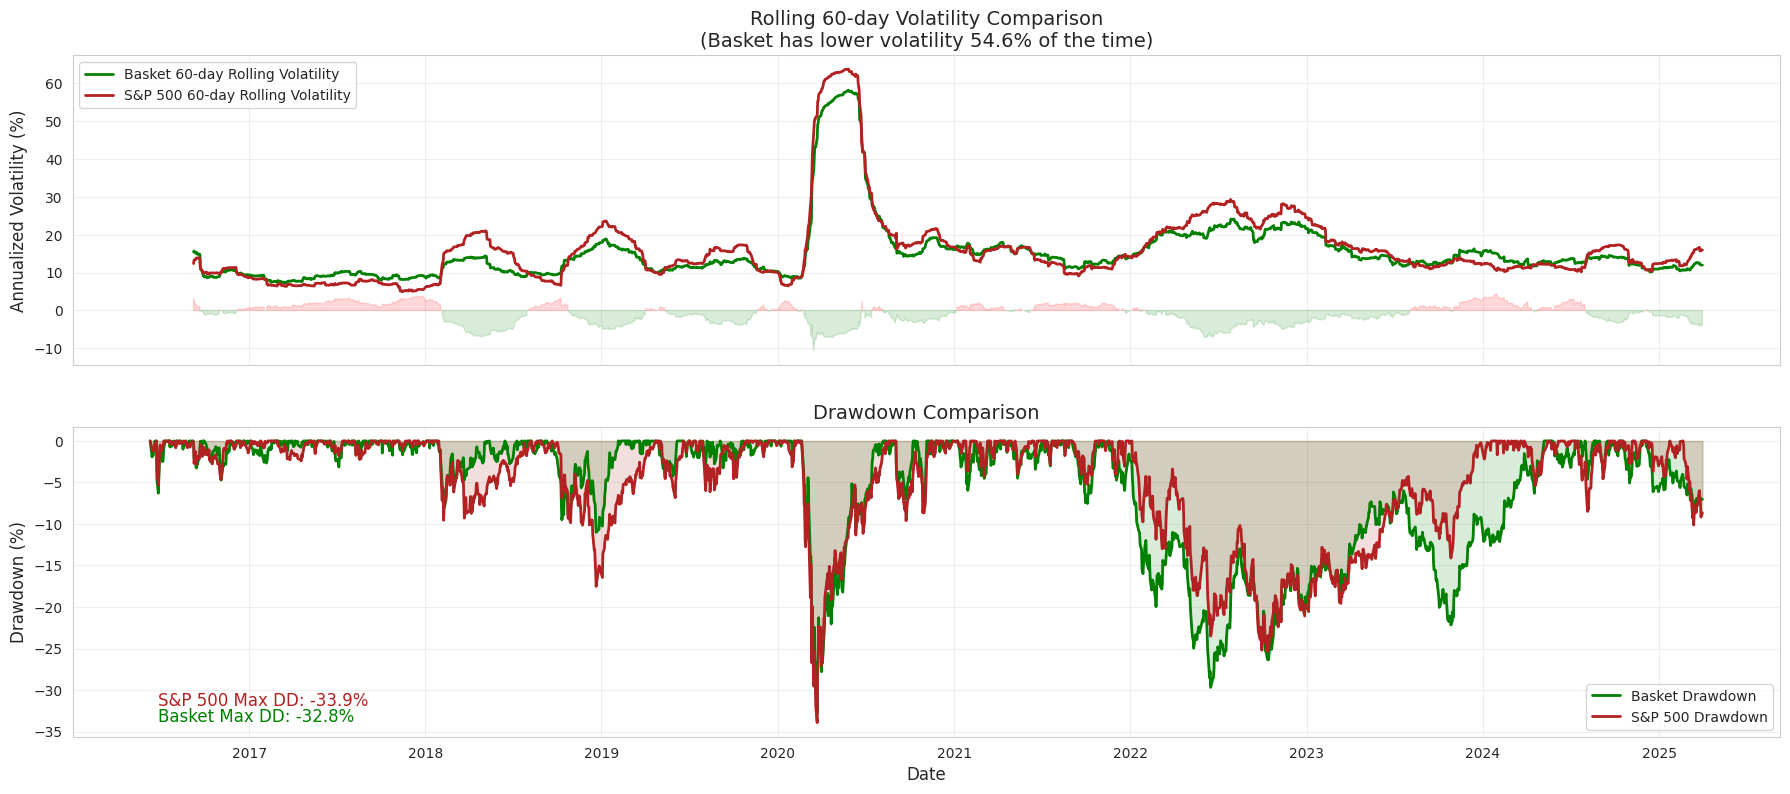

In [361]:
# Extract Rolling Volatility and Drawdown Comparison from the risk figure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate rolling volatilities and drawdowns using the existing data
# Ensure date alignment for fair comparison
basket_returns_series = basket_index.pct_change().dropna()
sp500_returns_series = normalized_benchmarks['^GSPC'].pct_change().dropna()

# Get common dates
common_dates = basket_returns_series.index.intersection(sp500_returns_series.index)
basket_returns_aligned = basket_returns_series.loc[common_dates]
sp500_returns_aligned = sp500_returns_series.loc[common_dates]

# Metrics for calculations
annual_factor = 252  # Trading days in a year

# Create a figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(18, 8), sharex=True)

# 1. TOP PLOT: Rolling Volatility Comparison
window = 60  # 3-month window (approximately)
basket_rolling_vol = basket_returns_aligned.rolling(window=window).std() * np.sqrt(annual_factor) * 100
sp500_rolling_vol = sp500_returns_aligned.rolling(window=window).std() * np.sqrt(annual_factor) * 100

# Plot rolling volatilities
axes[0].plot(basket_rolling_vol, color='green', linewidth=2, label=f'Basket {window}-day Rolling Volatility')
axes[0].plot(sp500_rolling_vol, color='firebrick', linewidth=2, label=f'S&P 500 {window}-day Rolling Volatility')

# Calculate and display the percentage of time basket has lower volatility
lower_vol_pct = (basket_rolling_vol < sp500_rolling_vol).mean() * 100
axes[0].set_title(f'Rolling {window}-day Volatility Comparison\n(Basket has lower volatility {lower_vol_pct:.1f}% of the time)', 
                 fontsize=14)
axes[0].set_ylabel('Annualized Volatility (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper left')

# Highlight volatility differences
vol_diff = basket_rolling_vol - sp500_rolling_vol
axes[0].fill_between(vol_diff.index, 0, vol_diff,
                    where=vol_diff < 0, color='green', alpha=0.15,
                    label='Basket Volatility Advantage')
axes[0].fill_between(vol_diff.index, 0, vol_diff,
                    where=vol_diff > 0, color='red', alpha=0.15,
                    label='S&P 500 Volatility Advantage')

# 2. BOTTOM PLOT: Drawdown Analysis
# Calculate prices for each asset
basket_prices = basket_index.loc[common_dates]
sp500_prices = normalized_benchmarks['^GSPC'].loc[common_dates]

# Calculate rolling drawdowns
basket_drawdown = basket_prices / basket_prices.cummax() - 1
sp500_drawdown = sp500_prices / sp500_prices.cummax() - 1

# Calculate max drawdowns
basket_max_dd = basket_drawdown.min() * 100
sp500_max_dd = sp500_drawdown.min() * 100

# Plot drawdowns
axes[1].plot(basket_drawdown*100, color='green', linewidth=2, label='Basket Drawdown')
axes[1].plot(sp500_drawdown*100, color='firebrick', linewidth=2, label='S&P 500 Drawdown')
axes[1].fill_between(basket_drawdown.index, 0, basket_drawdown*100, color='green', alpha=0.15)
axes[1].fill_between(sp500_drawdown.index, 0, sp500_drawdown*100, color='firebrick', alpha=0.15)

axes[1].set_title('Drawdown Comparison', fontsize=14)
axes[1].set_ylabel('Drawdown (%)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='lower right')

# Add annotations for max drawdowns
axes[1].annotate(f"Basket Max DD: {basket_max_dd:.1f}%", 
                xy=(0.05, 0.05), xycoords='axes fraction', 
                color='green', fontsize=12)
axes[1].annotate(f"S&P 500 Max DD: {sp500_max_dd:.1f}%", 
                xy=(0.05, 0.1), xycoords='axes fraction', 
                color='firebrick', fontsize=12)

# Overall plot title
# fig.suptitle('Vital Industries Basket: Risk Metrics Comparison', fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.2, top=0.93)
plt.show()

## Appendix

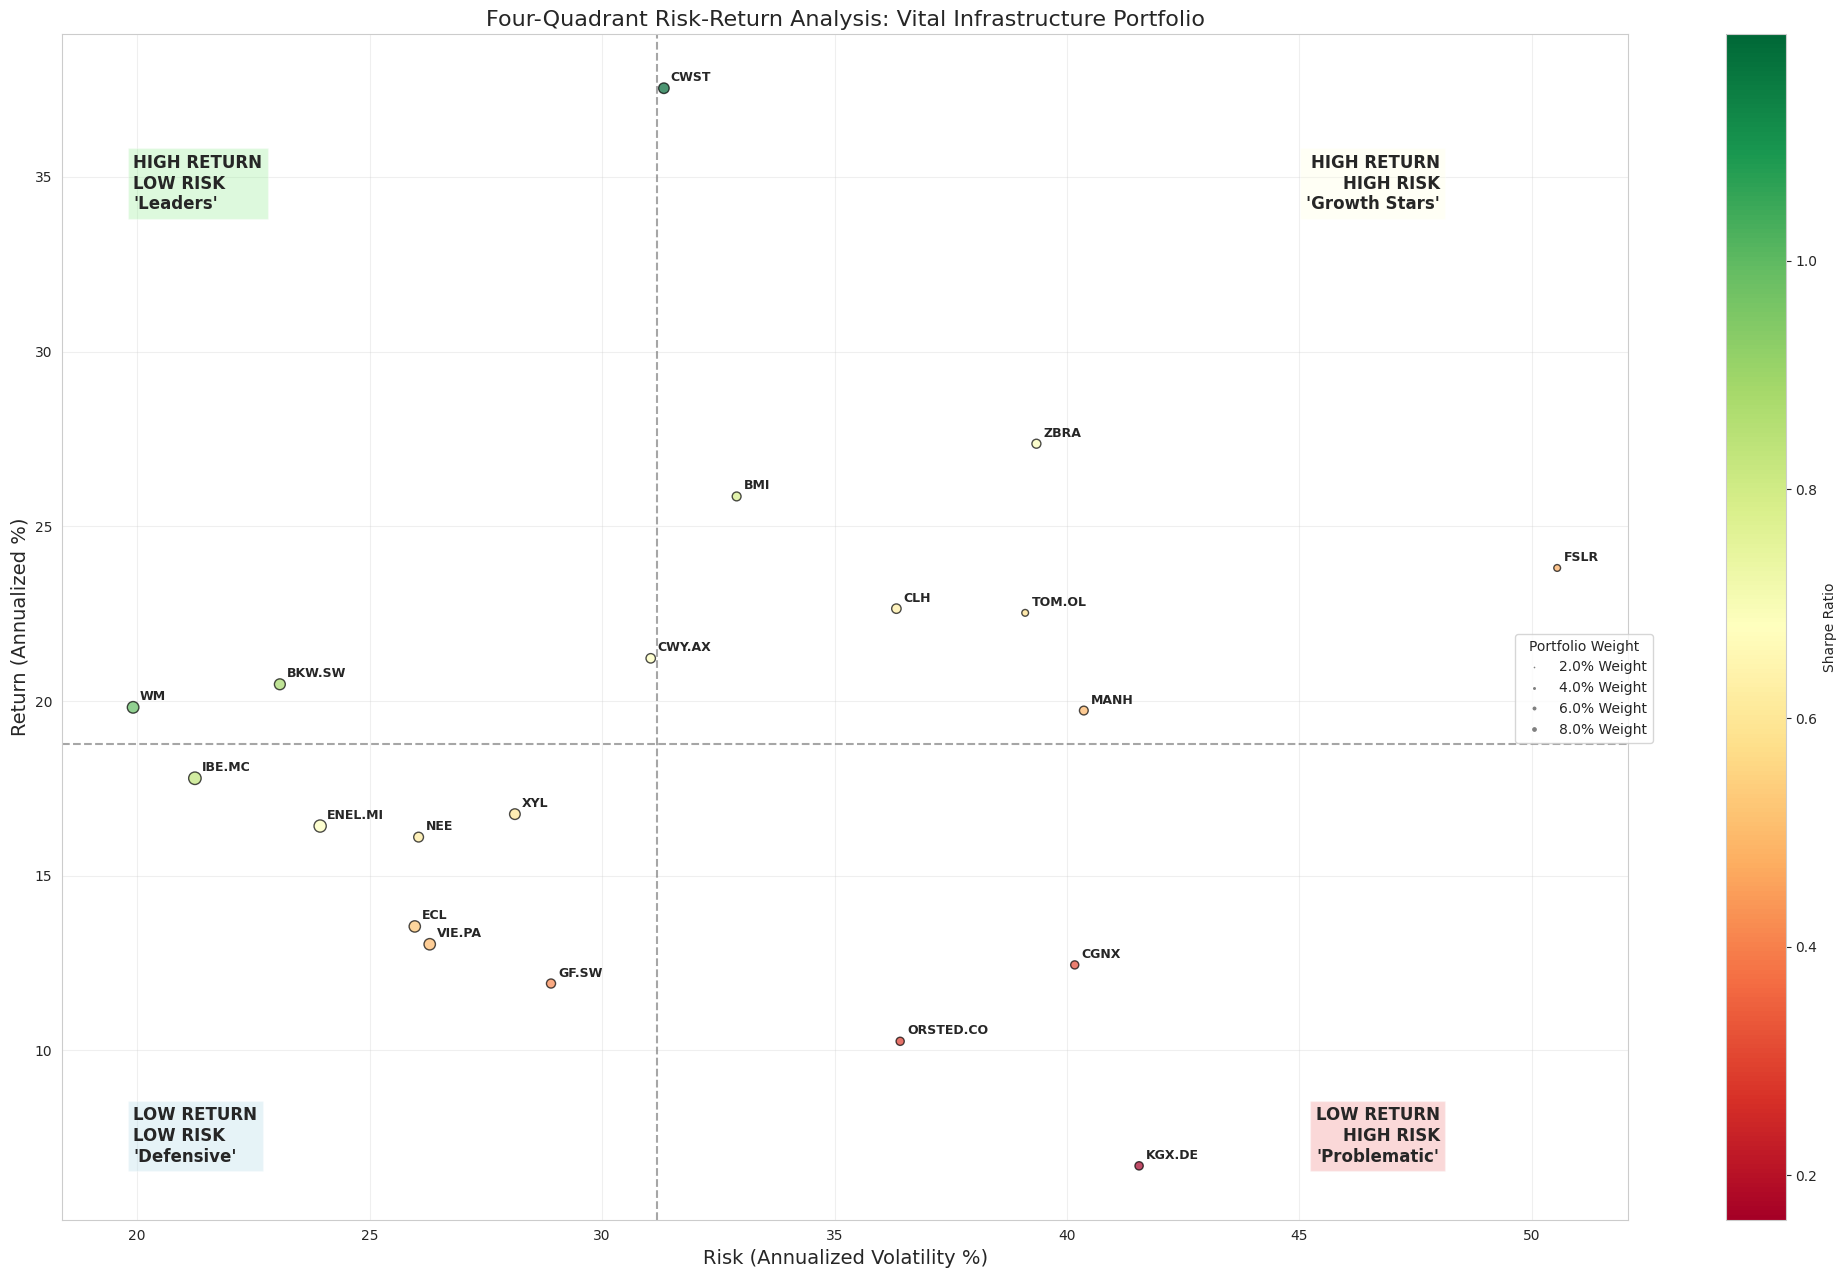

In [362]:
# Four-quadrant risk-return analysis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Calculate metrics for each stock
stock_metrics = {}
for ticker in valid_weights.index:
    # Calculate returns
    returns = data[ticker].pct_change().dropna()
    
    # Calculate annualized return and volatility
    annual_return = returns.mean() * 252 * 100  # Annualized percentage
    volatility = returns.std() * np.sqrt(252) * 100  # Annualized percentage
    sharpe = annual_return / volatility if volatility > 0 else 0
    
    # Store metrics
    stock_metrics[ticker] = {
        'Return': annual_return,
        'Risk': volatility,
        'Sharpe': sharpe,
        'Weight': valid_weights[ticker]
    }

# Convert to DataFrame for plotting
metrics_df = pd.DataFrame.from_dict(stock_metrics, orient='index')

# Calculate median values for dividing the quadrants
median_return = metrics_df['Return'].median()
median_risk = metrics_df['Risk'].median()

# Set up the plot with explicit axes object
fig, ax = plt.subplots(figsize=(24, 14))

# Define color mapping based on Sharpe ratio
cmap = plt.cm.RdYlGn  # Red-Yellow-Green colormap
norm = plt.Normalize(metrics_df['Sharpe'].min(), metrics_df['Sharpe'].max())
colors = [cmap(norm(sharpe)) for sharpe in metrics_df['Sharpe']]

# Create the scatter plot with bubble size based on weight
scatter = ax.scatter(
    metrics_df['Risk'], 
    metrics_df['Return'], 
    s=metrics_df['Weight']*1000,  # Scale weights for visibility
    c=colors,
    alpha=0.7,
    edgecolors='black'
)

# Add ticker labels to each point
for ticker, row in metrics_df.iterrows():
    ax.annotate(
        ticker, 
        (row['Risk'], row['Return']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9,
        fontweight='bold'
    )

# Draw quadrant lines
ax.axhline(y=median_return, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=median_risk, color='gray', linestyle='--', alpha=0.7)

# Add quadrant labels
ax.text(metrics_df['Risk'].min(), metrics_df['Return'].max()*0.95, 
       "HIGH RETURN\nLOW RISK\n'Leaders'", 
       fontsize=12, fontweight='bold', ha='left', va='top',
       bbox=dict(facecolor='lightgreen', alpha=0.3))

ax.text(metrics_df['Risk'].max()*0.95, metrics_df['Return'].max()*0.95, 
       "HIGH RETURN\nHIGH RISK\n'Growth Stars'", 
       fontsize=12, fontweight='bold', ha='right', va='top',
       bbox=dict(facecolor='lightyellow', alpha=0.3))

ax.text(metrics_df['Risk'].min(), metrics_df['Return'].min(), 
       "LOW RETURN\nLOW RISK\n'Defensive'", 
       fontsize=12, fontweight='bold', ha='left', va='bottom',
       bbox=dict(facecolor='lightblue', alpha=0.3))

ax.text(metrics_df['Risk'].max()*0.95, metrics_df['Return'].min(), 
       "LOW RETURN\nHIGH RISK\n'Problematic'", 
       fontsize=12, fontweight='bold', ha='right', va='bottom',
       bbox=dict(facecolor='lightcoral', alpha=0.3))

# Add titles and labels
ax.set_title('Four-Quadrant Risk-Return Analysis: Vital Infrastructure Portfolio', fontsize=16)
ax.set_xlabel('Risk (Annualized Volatility %)', fontsize=14)
ax.set_ylabel('Return (Annualized %)', fontsize=14)

# Create a colorbar legend for Sharpe ratio - fixed by passing scatter as mappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Sharpe Ratio')

# Add legend for bubble size
sizes = [0.02, 0.04, 0.06, 0.08]
labels = [f"{s*100:.1f}% Weight" for s in sizes]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           markerfacecolor='gray', markersize=np.sqrt(s*1000)/2, 
           label=l) for s, l in zip(sizes, labels)
]
ax.legend(handles=legend_elements, title="Portfolio Weight", 
         loc='upper right', bbox_to_anchor=(1.02, 0.5))

# Add text explaining the quadrants
# explanation = (
#     "QUADRANT ANALYSIS:\n\n"
#     "LEADERS (Top Left): High return with lower risk - these stocks offer the best risk-adjusted returns\n\n"
#     "GROWTH STARS (Top Right): High return but higher risk - these deliver strong growth with more volatility\n\n"
#     "DEFENSIVE (Bottom Left): Lower return but with lower risk - these provide stability\n\n"
#     "PROBLEMATIC (Bottom Right): Higher risk without commensurate returns - consider reducing exposure"
# )
# plt.figtext(0.5, 0.01, explanation, ha='center', fontsize=10, 
        #   bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout(rect=[0, 0.08, 0.85, 1])
plt.grid(alpha=0.3)
plt.show()

/tmp/ipykernel_709957/2063896983.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  basket_monthly = basket_index.resample('M').last().pct_change().dropna()
/tmp/ipykernel_709957/2063896983.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  benchmark_monthly = normalized_benchmarks['^GSPC'].resample('M').last().pct_change().dropna()


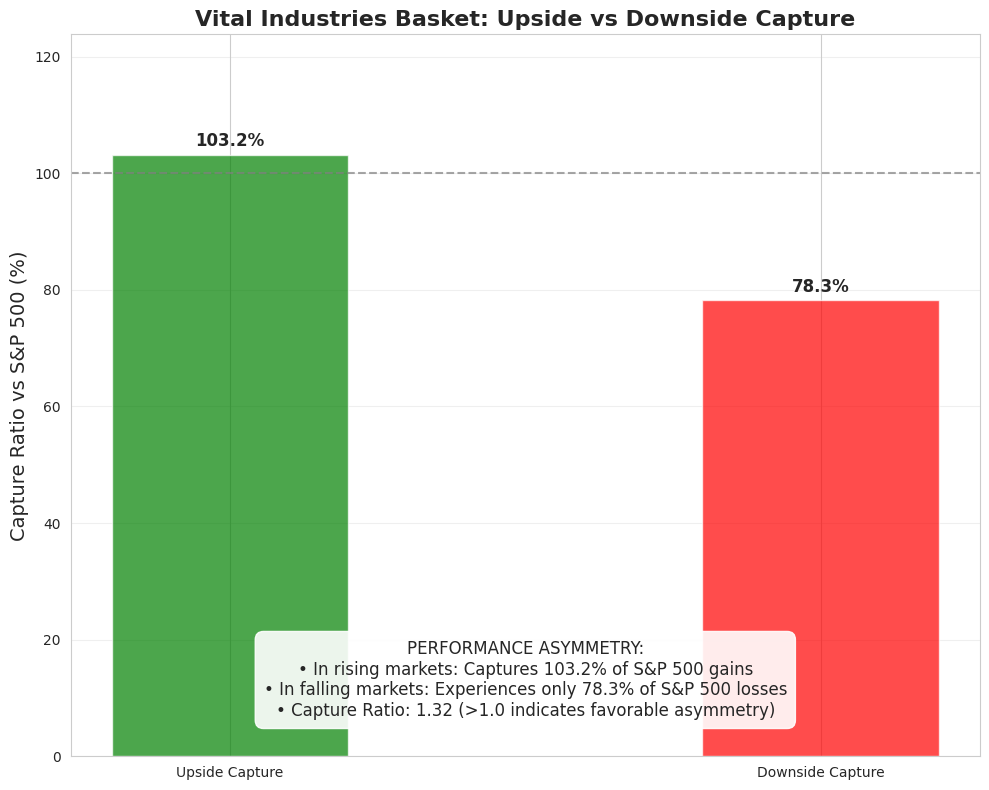

In [363]:
# Upside Capture vs Downside Capture - Standalone Bar Chart
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Calculate monthly returns
basket_monthly = basket_index.resample('M').last().pct_change().dropna()
benchmark_monthly = normalized_benchmarks['^GSPC'].resample('M').last().pct_change().dropna()

# Align the data
common_idx = basket_monthly.index.intersection(benchmark_monthly.index)
basket_monthly_aligned = basket_monthly.loc[common_idx]
benchmark_monthly_aligned = benchmark_monthly.loc[common_idx]

# Calculate upside and downside months
up_months_mask = benchmark_monthly_aligned > 0
down_months_mask = benchmark_monthly_aligned < 0

# Calculate upside and downside capture
upside_capture = (basket_monthly_aligned[up_months_mask].mean() / 
                 benchmark_monthly_aligned[up_months_mask].mean()) * 100
                 
downside_capture = (basket_monthly_aligned[down_months_mask].mean() / 
                  benchmark_monthly_aligned[down_months_mask].mean()) * 100

# Calculate capture ratio
capture_ratio = abs(upside_capture / downside_capture)

# Prepare data for the chart
metrics = {
    'Capture Type': ['Upside Capture', 'Downside Capture'],
    'Value (%)': [upside_capture, downside_capture]
}

df = pd.DataFrame(metrics)

# Create the bar chart
colors = ['green' if x == 'Upside Capture' else 'red' for x in df['Capture Type']]
bars = plt.bar(df['Capture Type'], df['Value (%)'], color=colors, alpha=0.7, width=0.4)

# Add ideal line at 100%
plt.axhline(y=100, color='grey', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    label_text = f"{height:.1f}%"
    plt.annotate(label_text,
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12,
                fontweight='bold')

# Customize chart
plt.ylabel('Capture Ratio vs S&P 500 (%)', fontsize=14)
plt.title('Vital Industries Basket: Upside vs Downside Capture', fontsize=16, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(df['Value (%)']) * 1.2)  # Add some space for the labels

# Add a text explanation about what this means
text_explanation = (
    f"PERFORMANCE ASYMMETRY:\n"
    f"• In rising markets: Captures {upside_capture:.1f}% of S&P 500 gains\n"
    f"• In falling markets: Experiences only {downside_capture:.1f}% of S&P 500 losses\n"
    f"• Capture Ratio: {capture_ratio:.2f} (>1.0 indicates favorable asymmetry)"
)

plt.text(0.5, 0.05, text_explanation, transform=plt.gca().transAxes, 
         ha='center', va='bottom', fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()